In [ ]:
!git clone https://github.com/pytorch/opacus.git
!cd opacus && pip install -e . --user

In [ ]:
pip install opacus==0.10.0

In [ ]:

import time as t
import os
#from utils.tensorboard_logger import Logger
from itertools import chain
from torchvision import utils

SAVE_PER_TIMES = 100

In [6]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from torchvision.utils import make_grid
from torch.nn import functional as F

from scipy.linalg import sqrtm
from opacus import PrivacyEngine
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [7]:
def load_train_data():
    X = []
    for i in range(5):
        X_, _ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32))
    return X

def load_test_data():
    X_, _ = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32))
    return X

def set_seed(seed):
    np.random.seed(seed)

def ScaledSamples(N,size = 256):
  samples = np.random.randn(N,size)
  scales = np.random.randn(size)/10
  biases = np.random.randn(size)
  new = samples * np.expand_dims(scales,0) + np.expand_dims(biases,0)
  return new,scales,biases

def ScaledExtremeSamples(N,size = 256):
  samples = np.random.randn(N,size)
  scales = np.random.randn(size)*100
  biases = np.random.randn(size)
  new = samples * np.expand_dims(scales,0) + np.expand_dims(biases,0)
  return new

def GenerateScaledSamples(N,size = 256):
  samples = ScaledSamples(N,size)
  sig_samp = 1/(1+np.exp(-1*samples))
  return sig_samp

def GenerateScaledExtremeSamples(N,size = 256):
  samples = ScaledExtremeSamples(N,size)
  sig_samp = 1/(1+np.exp(-1*samples))
  return sig_samp

def GenerateBoxedSamples(N,size=256,boxes=2): #only works 16x16 for right now
  samples = ScaledSamples(N,size)
  tbt = [] #3x3 box
  for i in range(3):
    for j in range(3):
      tbt.append((i-1,j-1))

  for n in range(N):
    for b in range(boxes):
      place = np.random.randint(size)
      sign = np.random.randint(2)*2-1
      for dir in tbt:
        index = place +dir[0] + dir[1] * 16
        if index>=0 and index<size:
          samples[n,index] += sign * 10
  sig_samp = 1/(1+np.exp(-1*samples))
  return sig_samp

def MixtureGaussian(N,K):
  means = np.zeros((K,2))
  for k in range(K):
    theta = k / K * 2 * np.pi
    means[k] = [5*np.cos(theta),5*np.sin(theta)]
  indices = np.random.randint(K,size=(N,))
  noise = np.random.randn(N,2)
  randomcenters = means[indices]
  return randomcenters+noise




# Use this to put tensors on GPU/CPU automatically when defining tensors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu') 
device = torch.device('cpu') 


In [8]:
#train_samples = GenerateScaledSamples(30000)
#train_samples = GenerateScaledExtremeSamples(30000)
#train_samples = GenerateBoxedSamples(30000)
#train_samples = GenerateScaledSamples(1000,size=2)
train_samples,scales,biases = ScaledSamples(1000,size=2)
true_means = biases
true_vars = np.diag(scales)
print(true_means)
print(true_vars)

[-0.31781719  0.03930928]
[[-0.01008528  0.        ]
 [ 0.          0.04413328]]


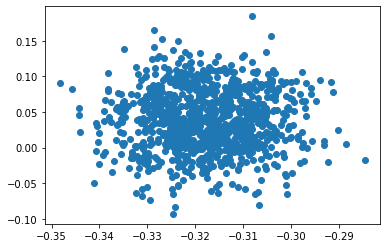

In [9]:
#fig = plt.figure(figsize = (8, 8))   
#ax1 = plt.subplot(111)
#ax1.imshow(make_grid(torch.from_numpy(train_samples[0:64]).view(-1,1,16,16), padding=1).numpy().transpose((1, 2, 0)))
#plt.show()
plt.scatter(train_samples[:,0],train_samples[:,1])
plt.show()

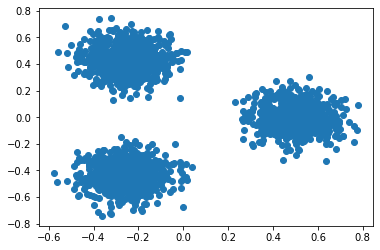

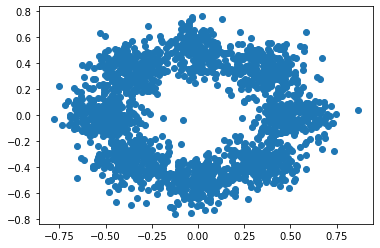

In [10]:
train_samples2 = MixtureGaussian(2000,3)/10
train_samples3 = MixtureGaussian(2000,8)/10

plt.scatter(train_samples2[:,0],train_samples2[:,1])
plt.show()
plt.scatter(train_samples3[:,0],train_samples3[:,1])
plt.show()



In [15]:

class SimpGen(nn.Module):
    def __init__(self, layers):
        super(SimpGen, self).__init__()
        
        self.length = len(layers)-1
        self.sizes = layers
        self.hiddens = nn.ModuleList()
        #self.norms = nn.ModuleList()
        for k in range(self.length):
          self.hiddens.append(  nn.Linear(layers[k],layers[k+1])  )
          #self.norms.append( nn.BatchNorm1d(layers[k+1] ))
        self.activation = nn.ReLU()

    def forward(self, x):
        h=x
        for k in range(self.length):
          h = self.hiddens[k](h)
          #h = self.norms[k](h)
          if k!=self.length-1:
            h = self.activation(h)
          else: #torch sigmoid for 2D example
            pass
            #h = self.activation(h) #JK that sucked (maybe)
            
            #h = torch.sigmoid(h)
            #h = 1 / (1+torch.exp(-1*h))
        return h

    def getGrad(self):
      grads = []
      for param in self.parameters():
        if param.grad is not None:
          grads.append(param.grad.view(-1).detach())
      grads = torch.cat(grads)
      #print(grads.shape)
      return grads


class SimpDisc(nn.Module):
    def __init__(self, layers):
        super(SimpDisc, self).__init__()
        
        self.length = len(layers)-1
        self.sizes = layers
        assert layers[self.length]==1
        self.hiddens = nn.ModuleList()
        #self.norms = nn.ModuleList()
        for k in range(self.length):
          self.hiddens.append(  nn.Linear(layers[k],layers[k+1])  )
          #self.norms.append( nn.BatchNorm1d(layers[k+1] ))
        self.activation = nn.ReLU()

    def forward(self, x):
        h=x
        for k in range(self.length):
          h = self.hiddens[k](h)
          if k>0:
            #h = self.norms[k](h)
            pass
          if k!=self.length-1:
            h = self.activation(h)
        return h
    
    def getGrad(self):
      grads = []
      for param in self.parameters():
        if param.grad is not None:
          grads.append(param.grad.view(-1).detach())
      grads = torch.cat(grads)
      #print(grads.shape)
      return grads




import torch.autograd as autograd
torch.autograd.set_detect_anomaly(True)

class SimpWGANGP(nn.Module):

    def __init__(self,dlayers,glayers,dloss,gloss,epochs,sample_size=None,compute_exact_w=False,privacy=False,nm=None,mg=None):
        super(SimpWGANGP, self).__init__()
        #self.num_epoch = 25
        self.num_epoch = epochs
        self.batch_size = 128
        self.log_step = 100 
        #self.visualize_step = 2 
        self.visualize_step = 20
        self.code_size = glayers[len(glayers)-1]
        self.g_learning_rate = gloss
        self.d_learning_rate = dloss
        self.vis_learning_rate = 1e-2
        
        self.compute_exact_w = compute_exact_w
        self.privacy = privacy
        
        # IID N(0, 1) Sample
        self.tracked_noise = torch.randn([64, self.code_size], device=device)        
        self._actmax_label = torch.ones([64, 1], device=device)


        
        #dlayers = [256, 128, 64, 1]
        #glayers = [256, 256, 256, 256]
        self._discriminator = SimpDisc(dlayers).to(device)
        self._generator = SimpGen(glayers).to(device)

        self._l2_loss = nn.MSELoss()
        self._classification_loss = nn.BCEWithLogitsLoss()

        betas = (0.5, 0.9)
        self._generator_optimizer = torch.optim.Adam(self._generator.parameters(),lr=self.g_learning_rate,betas=betas)
        self._discriminator_optimizer = torch.optim.Adam(self._discriminator.parameters(),lr=self.d_learning_rate,betas=betas)

        self._generator_optimizer = torch.optim.SGD(self._generator.parameters(),lr=self.g_learning_rate)
        self._discriminator_optimizer = torch.optim.SGD(self._discriminator.parameters(),lr=self.d_learning_rate)
        
        if self.privacy:
            self.privacy_engine = PrivacyEngine(
                self._discriminator,
                2*self.batch_size,
                sample_size,
                alphas=[10, 100],
                #noise_multiplier=1.3,
                noise_multiplier=nm,
                #max_grad_norm=1.0,
                max_grad_norm=mg,
            )
            self.privacy_engine.attach(self._discriminator_optimizer)
            
            
            self.gping = False
            for layer in self.modules():
                layer.gping = False

    def _loss(self, real_log, fake_log):
      D_fake = fake_log
      D_real = real_log
      loss = D_fake - D_real
      return loss
      
    def _reconstruction_loss(self, generated, target):
        return self._l2_loss(generated, target)

    def calc_gradient_penalty(self, real_data, fake_data): #from wgan github
        LAMBDA = 10

        alpha = torch.rand(self.batch_size, 1)
        alpha = alpha.expand(real_data.size())
        alpha = alpha.to(device)

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)
        interpolates = interpolates.to(device)

        interpolates = autograd.Variable(interpolates, requires_grad=True)

        #print('interpolating')
        disc_interpolates = self._discriminator(interpolates)
        
        #print('gradienting')
        self.gping = True
        for layer in self.modules():
            layer.gping = True
        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                  create_graph=True, retain_graph=True, only_inputs=True,allow_unused=True)[0]
        self.gping = False
        for layer in self.modules():
            layer.gping = False
        
        #print('grad shape',gradients.shape)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
        return gradient_penalty

    # Training function
    def train(self, train_samples):
        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        smooth_factor = 0
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        dis_grads = []
        gen_grads = []
        w_dists = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        fake_label = torch.zeros([self.batch_size, 1], device=device)
        real_label = torch.ones([self.batch_size, 1], device=device)
        self._generator.train()
        self._discriminator.train()
        print('Start training ...')
        for epoch in range(self.num_epoch):
            print('EP',epoch)
            np.random.shuffle(train_samples)
            for i in range(num_train // self.batch_size):
                print('batch #',i)
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                batch_samples = torch.Tensor(batch_samples).to(device)

                ################################################################################
                # Prob 2-1: Train the discriminator on all-real images first                   #
                ################################################################################
                DISC_STEPS = 5
                for _ in range(DISC_STEPS):
                  self._discriminator_optimizer.zero_grad()

                  real_dis_out = self._discriminator(batch_samples)

                  noise =  torch.randn((self.batch_size,self.code_size),device=device)# IID Normal(0, 1)^d on the torch device
                  fake_samples = self._generator(noise)
                  fake_dis_out = self._discriminator(fake_samples.detach())

                  #print('DISC LOSS 1')
                  disc_loss1 = fake_dis_out - real_dis_out
                  disc_loss1 = disc_loss1.mean()
                  disc_loss1.backward(retain_graph=False)
                  #disc_loss1.backward(retain_graph=True)
                  
                  if self.privacy:
                      #print('GRAD PENALTY')
                      gp = self.calc_gradient_penalty(batch_samples,fake_samples.detach())
                      #print('take it back now')
                      gp.backward(retain_graph=True)

                      dis_grad = torch.norm(self._discriminator.getGrad())
                      self._discriminator_optimizer.step()
                      #dis_loss = disc_loss1.cpu().detach() + gp.cpu().detach()
                      dis_loss = disc_loss1.cpu().detach()
                      dis_losses.append(dis_loss)
                  else:
                      gp = self.calc_gradient_penalty(batch_samples,fake_samples.detach())
                      gp.backward(retain_graph=True)

                      dis_grad = torch.norm(self._discriminator.getGrad())
                      self._discriminator_optimizer.step()
                      dis_loss = disc_loss1.cpu().detach() + gp.cpu().detach()
                      dis_losses.append(dis_loss)
                    

                ################################################################################
                # Prob 2-1: Train the generator                                                #
                ################################################################################             
                self._generator_optimizer.zero_grad()

                fake_samples2 = self._generator(noise)
                fake_dis_out2 = self._discriminator(fake_samples2)

                gen_loss1 = -fake_dis_out2
                gen_loss1 = gen_loss1.mean()
                gen_loss1.backward(retain_graph=True)

                gen_grad = torch.norm(self._generator.getGrad())
                self._generator_optimizer.step()
                gen_loss = gen_loss1.cpu().detach()

                if self.compute_exact_w:
                  fake_vars =  (self._generator.hiddens[0].weight.cpu().detach().numpy())
                  fake_means = (self._generator.hiddens[0].bias.cpu().detach().numpy())
                  fake_sqrt = sqrtm(fake_vars)
                  wd1 = np.sum(np.square(true_means-fake_means))
                  wd2 = np.trace(  true_vars + fake_vars - 2 *sqrtm(np.matmul(fake_sqrt,np.matmul(true_vars,fake_sqrt))) ) 
#try again
                  wd1 = np.sum(np.square(true_means-fake_means))
                  wd2 = np.trace(  np.matmul(true_vars,true_vars) + np.matmul(fake_vars,fake_vars) - 2 *sqrtm(np.matmul(fake_vars,np.matmul(true_vars,np.matmul(true_vars,fake_sqrt)))) ) 
                  #print(wd1)
                  #print(wd2)
                  #print()
                  wd=wd1+wd2
                  w_dists.append(wd)
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################
                
                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                #dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                dis_grads.append(dis_grad)
                gen_grads.append(gen_grad)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))
            if epoch % self.visualize_step == 0:
                if self.compute_exact_w:
                  plt.plot(w_dists)
                  plt.title('exact wasserstein distance')
                  plt.show()

                plt.plot(dis_losses)
                plt.title('discriminator loss')
                plt.xlabel('iterations')
                plt.ylabel('loss')
                plt.show()
    
                plt.plot(gen_losses)
                plt.title('generator loss')
                plt.xlabel('iterations')
                plt.ylabel('loss')
                plt.show()

                plt.plot(dis_grads)
                plt.title('discriminator grads')
                plt.xlabel('iterations')
                plt.ylabel('grad norm')
                plt.show()
    
                plt.plot(gen_grads)
                plt.title('generator grads')
                plt.xlabel('iterations')
                plt.ylabel('grad norm')
                plt.show()

                '''
                fig = plt.figure(figsize = (8, 8))   
                ax1 = plt.subplot(111)
                ax1.imshow(make_grid( \
                                     self._generator(self.tracked_noise.detach()).cpu().detach().view(-1,1,16,16), padding=1, normalize=True).numpy().transpose((1, 2, 0) \
                                                                                                                                                                 ))
                plt.show()
                '''

                A=-1;B=1;D=21;

                self._generator.eval()
                self._discriminator.eval()
                
                noise_np = self.tracked_noise.cpu().detach().numpy()
                plt.scatter(noise_np[:,0],noise_np[:,1],c='r')
                plt.show()
                #plt.scatter(train_samples[:64,0],train_samples[:64,1])
                torch_gen_samp = self._generator(self.tracked_noise.detach())
                generated_samples = torch_gen_samp.cpu().detach().numpy()
                #plt.scatter(generated_samples[:,0],generated_samples[:,1],c='r')
                true_beliefs = torch.sigmoid(self._discriminator(torch.Tensor(train_samples[:64]).to(device))).cpu().detach().numpy()
                fake_beliefs = torch.sigmoid(self._discriminator(torch_gen_samp)).cpu().detach().numpy()
                true_colors = np.zeros((64,3))
                fake_colors = np.zeros((64,3))
                true_colors[:,2] = true_beliefs[:,0]
                fake_colors[:,0] = fake_beliefs[:,0]

                #plt.subplot(141)
                plt.scatter(train_samples[:64,0],train_samples[:64,1],s=50.,c=true_colors,alpha=0.3)
                plt.scatter(generated_samples[:64,0],generated_samples[:64,1],s=50.,c=fake_colors,alpha=0.3)
                plt.xlim(A,B)
                plt.ylim(A,B)
                plt.gca().set_aspect('equal','box')
                plt.show()

                x=np.linspace(A,B,D);y=np.linspace(A,B,D);
                xx,yy=np.meshgrid(x,y)
                test_grid=np.array((xx.ravel(), yy.ravel())).T     
                test_beliefs = torch.sigmoid(self._discriminator(torch.Tensor(test_grid).to(device))).cpu().detach().numpy()
                test_colors = np.zeros((test_grid.shape[0],3))
                test_colors2 = np.zeros((test_grid.shape[0],3))
                test_colors3 = np.zeros((test_grid.shape[0],3))
                test_colors[:,1] = test_beliefs[:,0]
                tmax=np.max(test_beliefs);tmin=np.min(test_beliefs);
                test_colors2[:,1] = (test_beliefs[:,0]-tmin)/(tmax-tmin)
                test_colors3[:,1] = (test_beliefs[:,0]>.5).astype(float)

                

                #plt.subplot(142)
                plt.scatter(test_grid[:,0],test_grid[:,1],s=88,c=test_colors,marker='s',alpha=0.3)
                plt.gca().set_aspect('equal','box')
                plt.show()
                #plt.subplot(143)
                plt.scatter(test_grid[:,0],test_grid[:,1],s=88,c=test_colors2,marker='s',alpha=0.3)
                plt.gca().set_aspect('equal','box')
                plt.show()
                #plt.subplot(144)
                plt.scatter(test_grid[:,0],test_grid[:,1],s=88,c=test_colors3,marker='s',alpha=0.3)
                plt.scatter(train_samples[:64,0],train_samples[:64,1],s=50.,c='b',alpha=0.3)
                plt.scatter(generated_samples[:64,0],generated_samples[:64,1],s=50.,c='r',alpha=0.3)
                plt.gca().set_aspect('equal','box')
                plt.show()
                
                self._generator.train()
                self._discriminator.train()

        print('... Done!')

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        recon_code = torch.zeros([samples.shape[0], self.code_size], device=device, requires_grad=True)
        samples = torch.tensor(samples, device=device, dtype=torch.float32)

        # Set the generator to evaluation mode, to make batchnorm stats stay fixed
        self._generator.eval()

        ################################################################################
        # Prob 2-4: complete the definition of the optimizer .                         #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # Use the vis learning rate
        recon_optimizer = torch.optim.Adam([recon_code], lr=self.vis_learning_rate) 
        
        for i in range(500):
            ################################################################################
            # Prob 2-4: Fill in the training loop for reconstruciton                       #
            # skip this part when working on problem 2-1 and come back for problem 2-4     #
            ################################################################################
            recon_optimizer.zero_grad()
            recon_samples = self._generator(recon_code)
            recon_loss = self._reconstruction_loss(recon_samples,samples)
            recon_loss.backward()
            recon_optimizer.step()
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
        return recon_loss, recon_samples.detach().cpu()
        

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, actmax_code):
        self._generator.eval()
        self._discriminator.eval() 
        ################################################################################
        # Prob 2-4: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        actmax_code = torch.tensor(actmax_code, device=device, dtype=torch.float32, requires_grad=True)
        actmax_optimizer = torch.optim.Adam([actmax_code], lr=self.vis_learning_rate) 
        for i in range(500):
            actmax_optimizer.zero_grad()
            actmax_sample = self._generator(actmax_code)
            actmax_dis = self._discriminator(actmax_sample)
            actmax_loss = self._loss(actmax_dis, self._actmax_label)
            actmax_loss.backward()
            actmax_optimizer.step()
        return actmax_sample.detach().cpu()

Start training ...


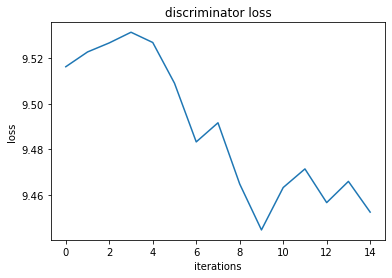

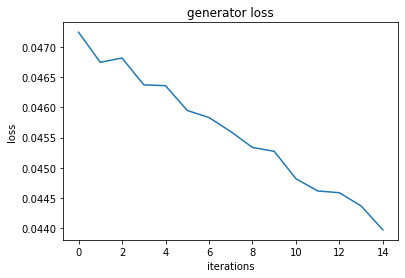

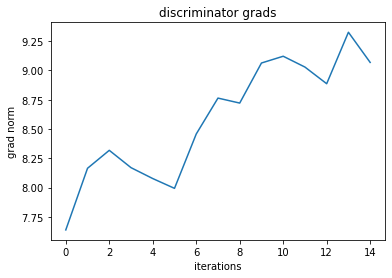

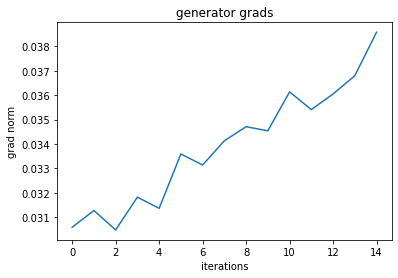

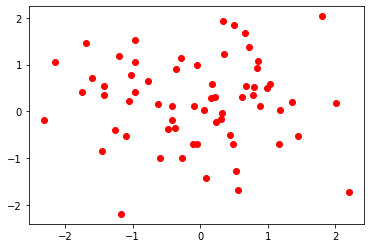

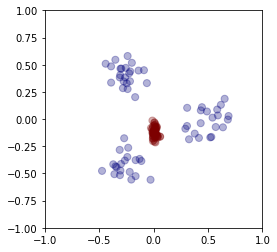

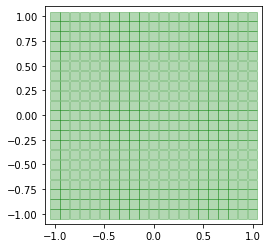

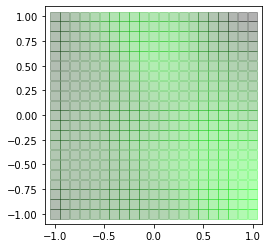

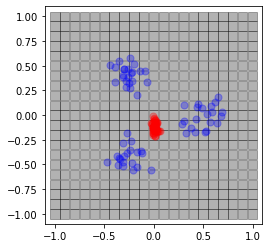

KeyboardInterrupt: 

In [40]:

dlayers = [2,32,16,16,1]
dloss = 1e-4
glayers = [2,32,16,4,2]
gloss = 1e-4
EP = 2000

dlayers = [2,256,256,256,1]
dloss = 1e-4
glayers = [2,256,256,256,2]
gloss = 1e-4
EP = 10000

dlayers = [2,64,64,64,1]
dloss = 1e-4
glayers = [2,64,64,64,2]
gloss = 1e-4
EP = 10000

#simpgan = SimpGAN(dlayers, glayers,dloss,gloss,EP)
simpgan = SimpWGANGP(dlayers, glayers,dloss,gloss,EP)
simpgan.train(train_samples2)
torch.save(simpgan.state_dict(), "simpwgangp_mog.pth")

/home/jaszy/opacus/opacus/privacy_engine.py:104: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/home/jaszy/opacus/opacus/privacy_engine.py:283: UserWarning: PrivacyEngine expected a batch of size 256 but the last step received a batch of size 128. This means that the privacy analysis will be a bit more pessimistic. You can set `drop_last = True` in your PyTorch dataloader to avoid this problem completely
  f"PrivacyEngine expected a batch of size {self.batch_size} "


Start training ...
EP 0
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


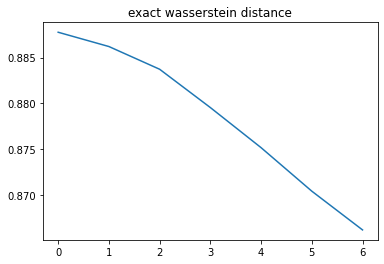

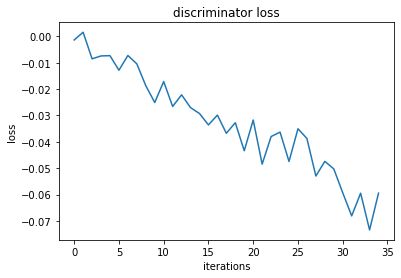

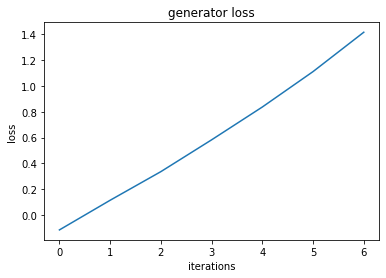

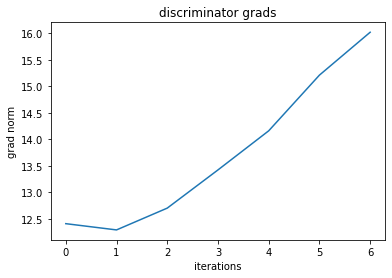

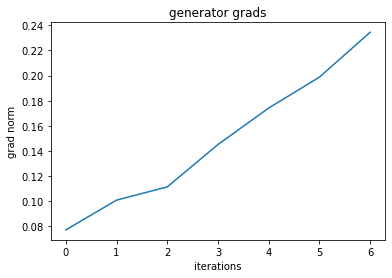

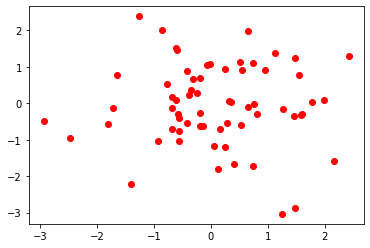

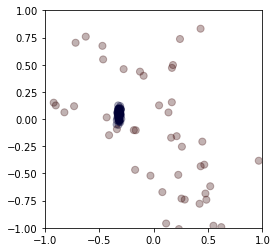

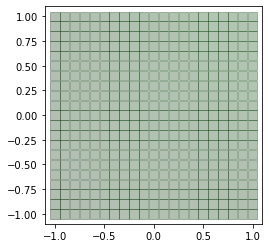

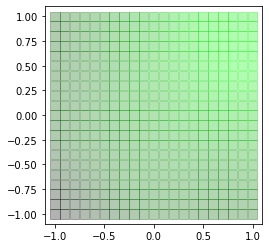

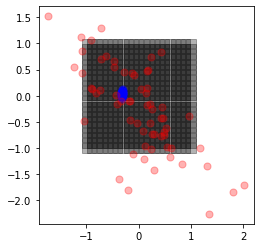

EP 1
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 2
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 3
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 4
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 5
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 6
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 7
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 8
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 9
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 10
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 11
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 12
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 13
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 14
batch # 0
batch

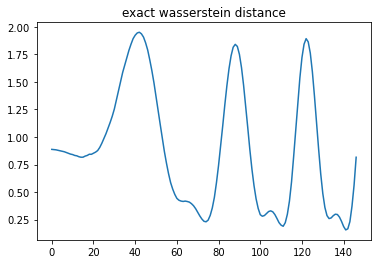

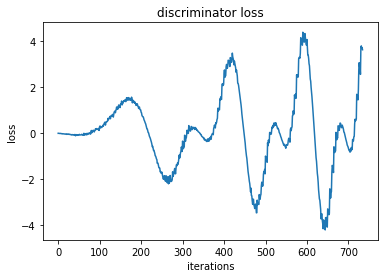

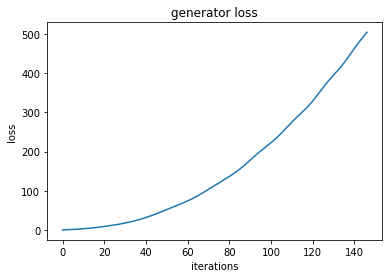

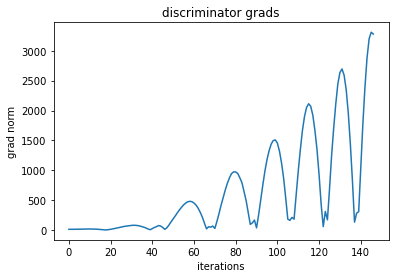

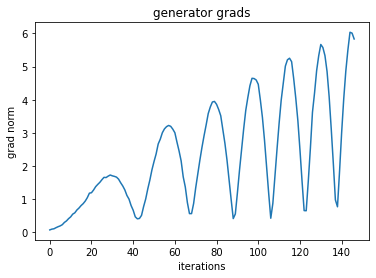

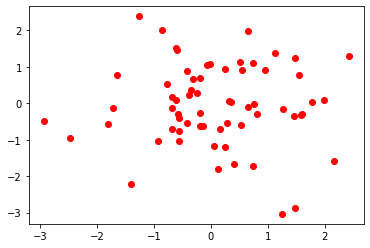

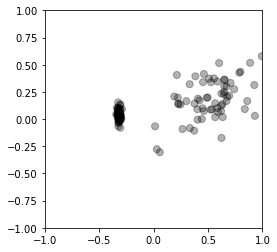

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:369: RuntimeWarning: invalid value encountered in true_divide


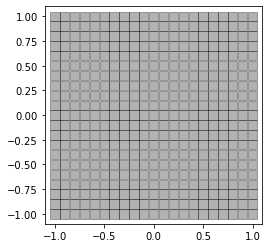

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:306: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:306: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


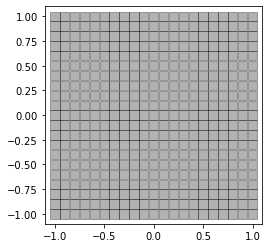

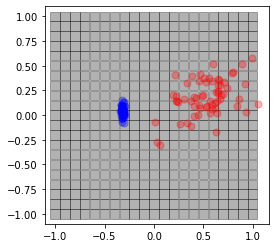

EP 21
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 22
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 23
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 24
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 25
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 26
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 27
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 28
batch # 0
batch # 1
batch # 2
batch # 3
Iteration 200/14000: dis loss = 6.3655, gen loss = 984.3364
batch # 4
batch # 5
batch # 6
EP 29
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 30
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 31
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 32
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 33
batch # 0
batch # 1
ba

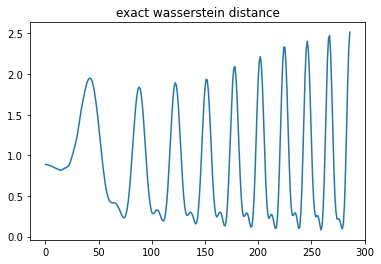

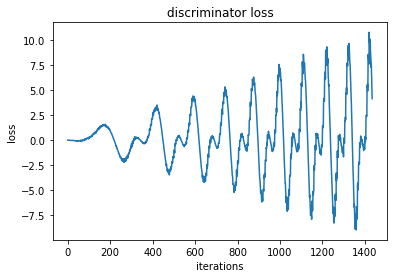

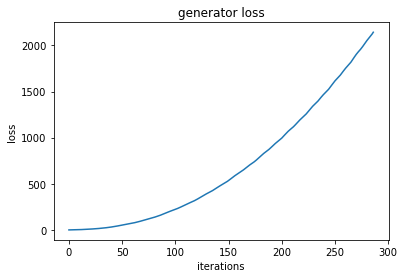

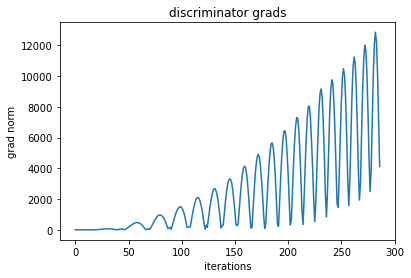

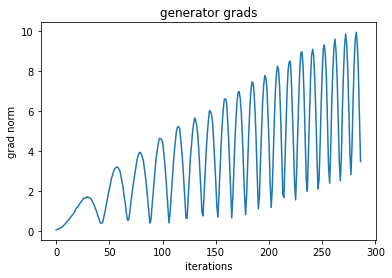

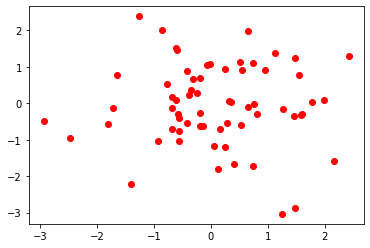

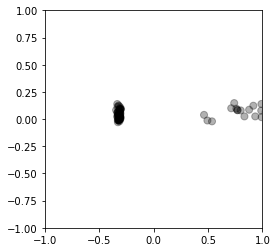

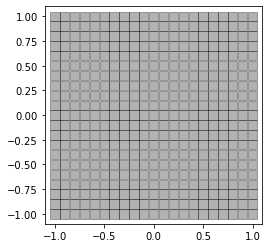

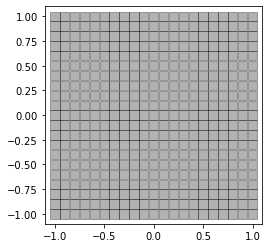

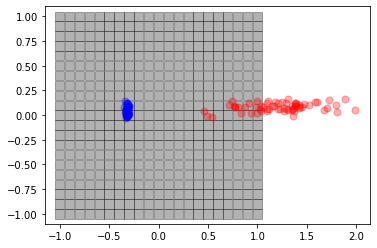

EP 41
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 42
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
Iteration 300/14000: dis loss = -0.0625, gen loss = 2360.0732
batch # 6
EP 43
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 44
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 45
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 46
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 47
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 48
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 49
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 50
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 51
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 52
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 53
batch # 0
batch # 1


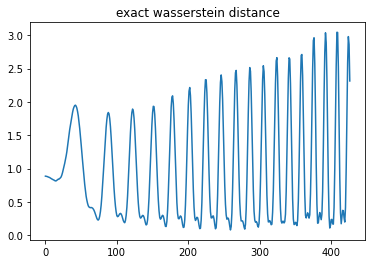

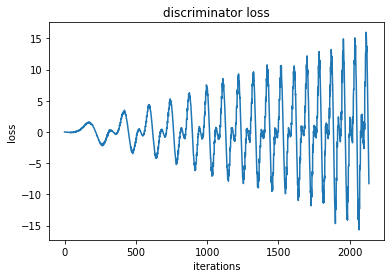

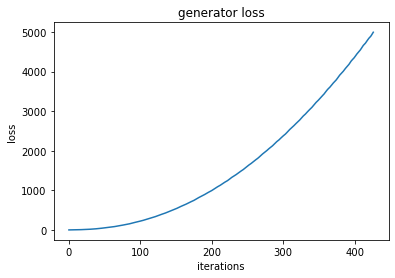

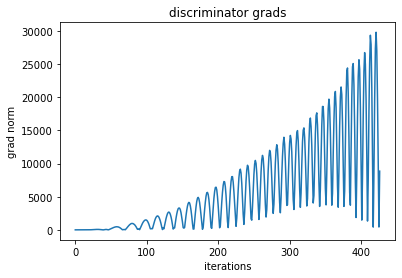

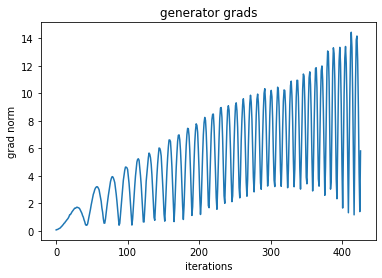

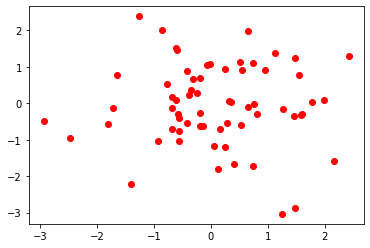

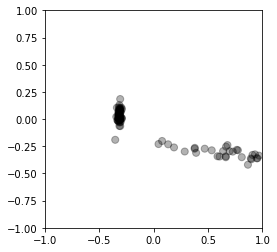

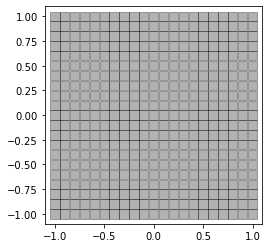

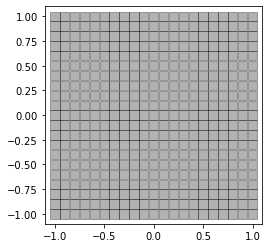

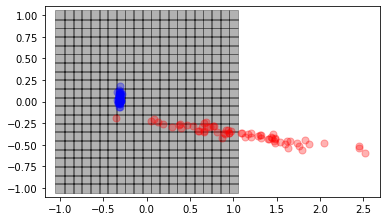

EP 61
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 62
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 63
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 64
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 65
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 66
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 67
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 68
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 69
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 70
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 71
batch # 0
batch # 1
batch # 2
Iteration 500/14000: dis loss = 13.2674, gen loss = 6934.5547
batch # 3
batch # 4
batch # 5
batch # 6
EP 72
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 73
batch # 0
batch # 1


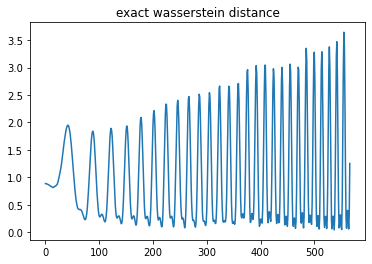

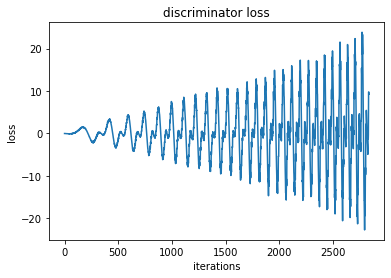

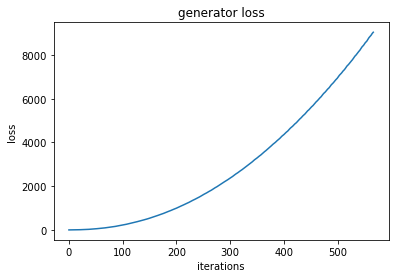

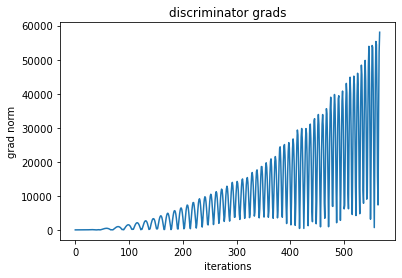

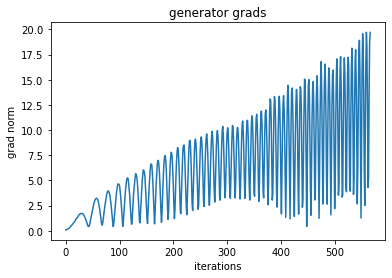

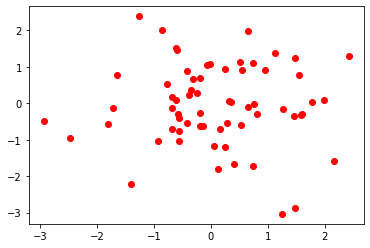

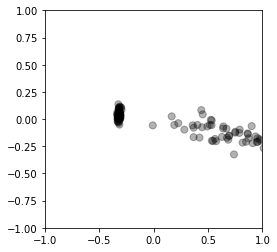

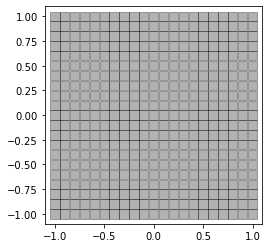

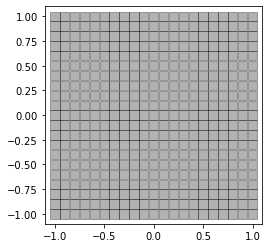

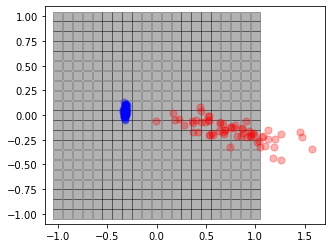

EP 81
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 82
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 83
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 84
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 85
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
Iteration 600/14000: dis loss = -18.0963, gen loss = 10182.7061
batch # 5
batch # 6
EP 86
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 87
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 88
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 89
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 90
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 91
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 92
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 93
batch # 0
batch # 

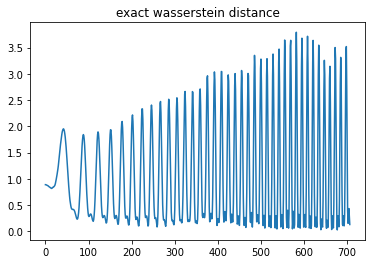

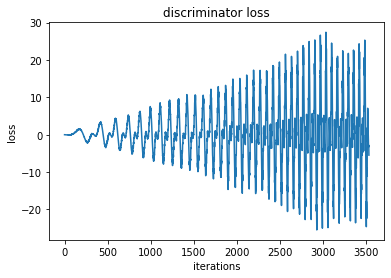

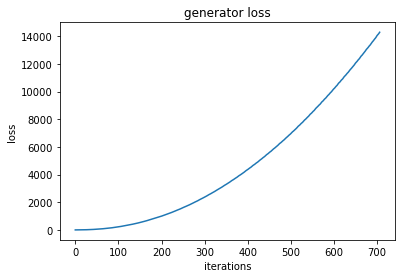

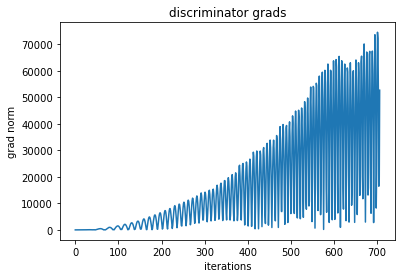

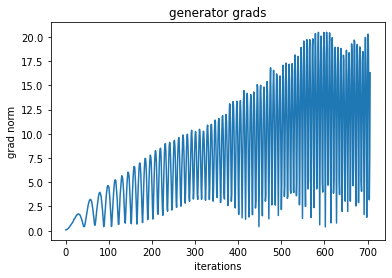

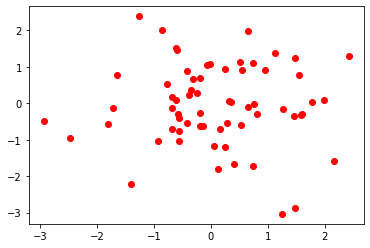

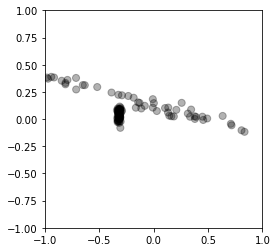

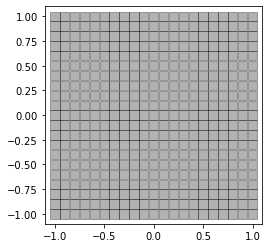

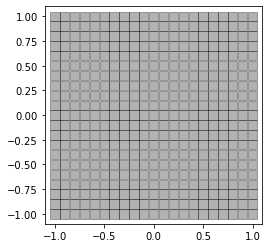

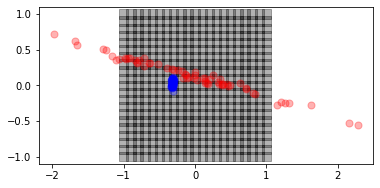

EP 101
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 102
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 103
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 104
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 105
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 106
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 107
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 108
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 109
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 110
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 111
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 112
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 113
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6

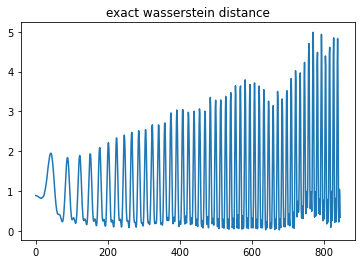

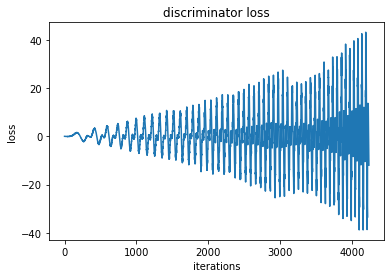

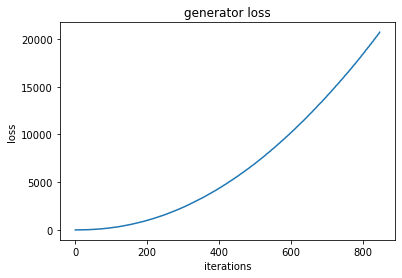

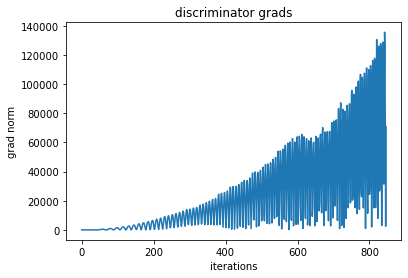

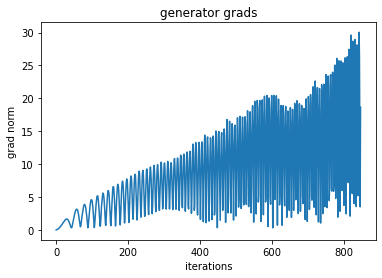

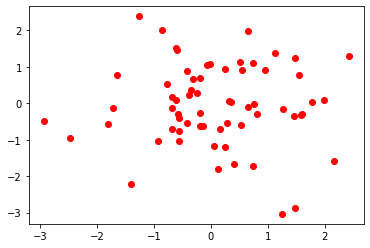

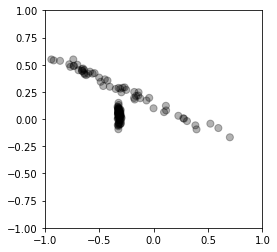

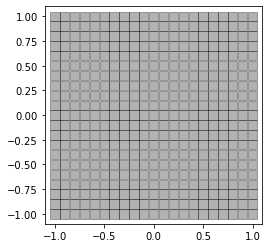

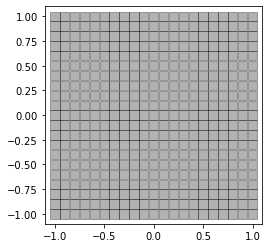

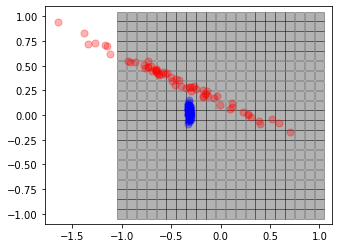

EP 121
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 122
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 123
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 124
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 125
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 126
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 127
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 128
batch # 0
batch # 1
batch # 2
batch # 3
Iteration 900/14000: dis loss = -5.4197, gen loss = 23379.9297
batch # 4
batch # 5
batch # 6
EP 129
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 130
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 131
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 132
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 133
batch 

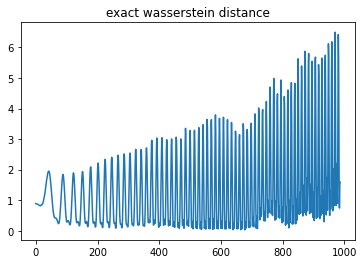

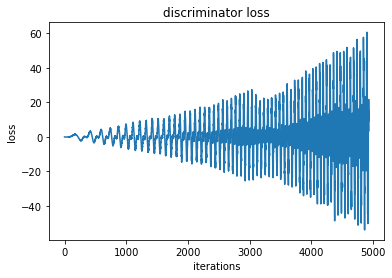

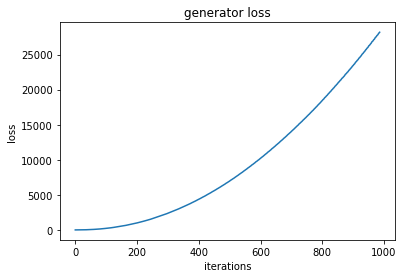

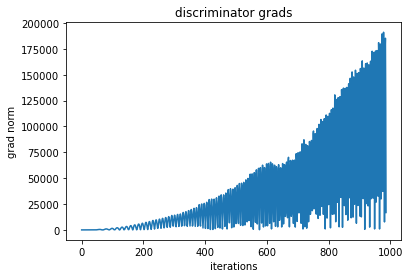

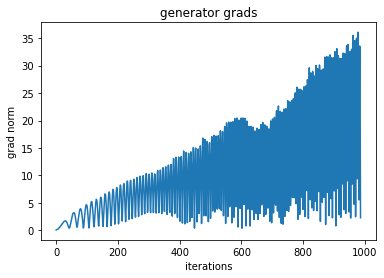

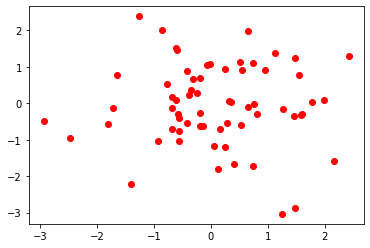

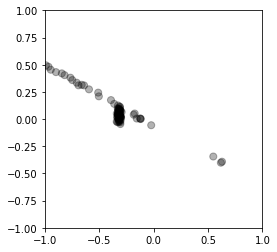

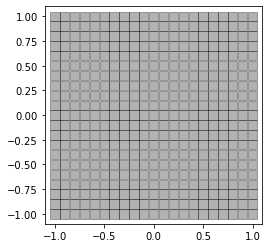

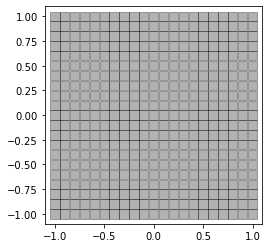

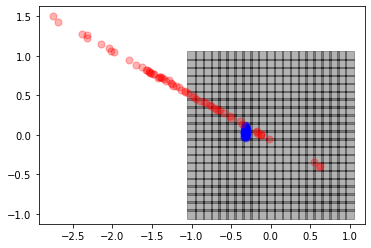

EP 141
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 142
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
Iteration 1000/14000: dis loss = 2.8344, gen loss = 28928.9375
batch # 6
EP 143
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 144
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 145
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 146
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 147
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 148
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 149
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 150
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 151
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 152
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 153
batch 

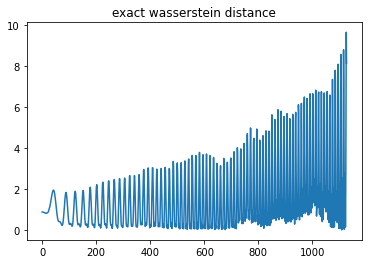

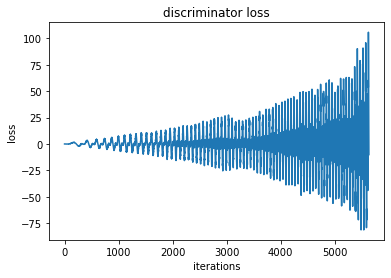

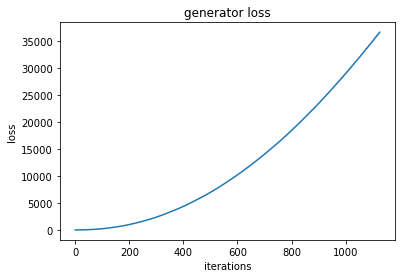

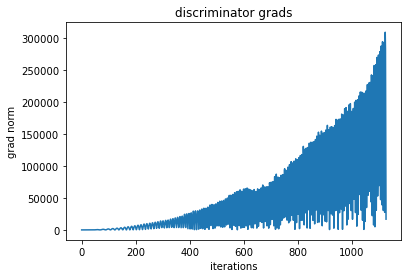

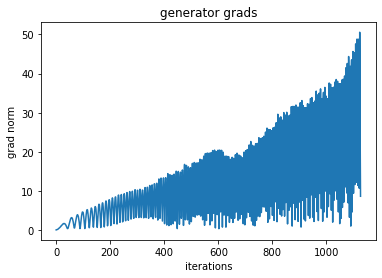

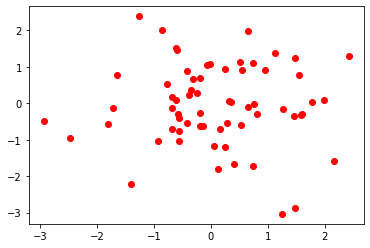

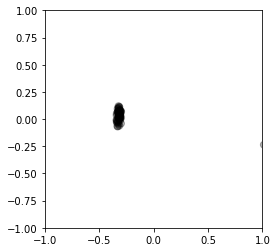

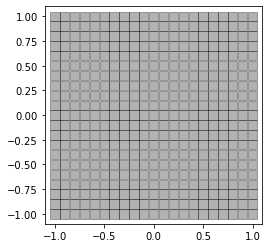

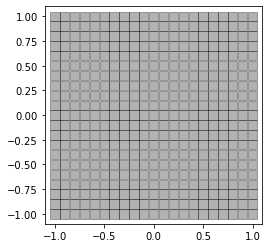

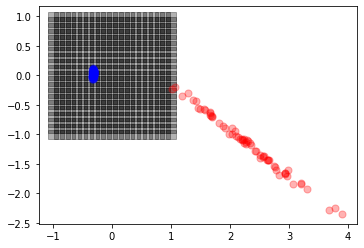

EP 161
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 162
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 163
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 164
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 165
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 166
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 167
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 168
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 169
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 170
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 171
batch # 0
batch # 1
batch # 2
Iteration 1200/14000: dis loss = 69.7825, gen loss = 41169.5078
batch # 3
batch # 4
batch # 5
batch # 6
EP 172
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 173
batch

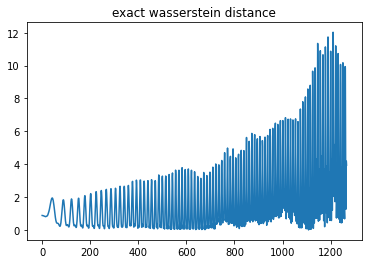

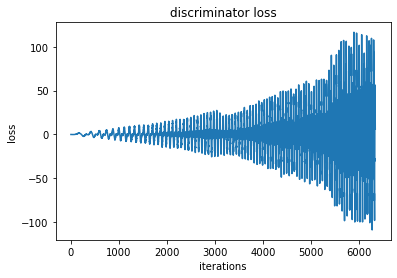

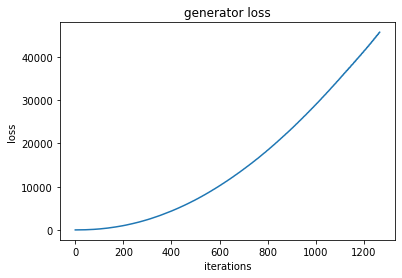

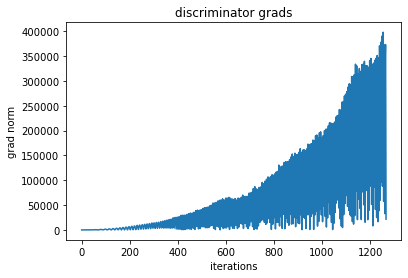

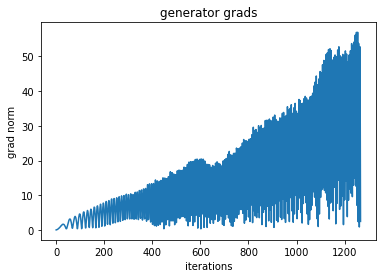

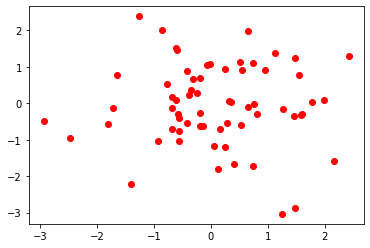

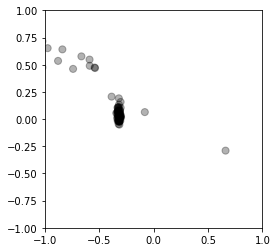

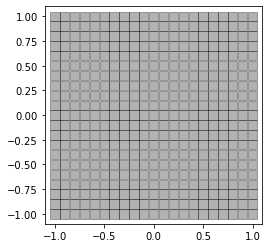

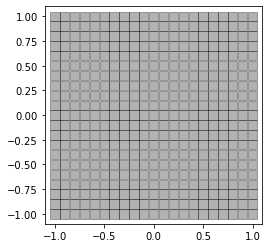

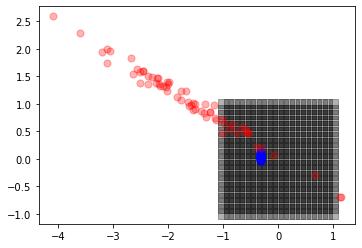

EP 181
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 182
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 183
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 184
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 185
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
Iteration 1300/14000: dis loss = 58.6205, gen loss = 48016.0547
batch # 5
batch # 6
EP 186
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 187
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 188
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 189
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 190
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 191
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 192
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 193
batch

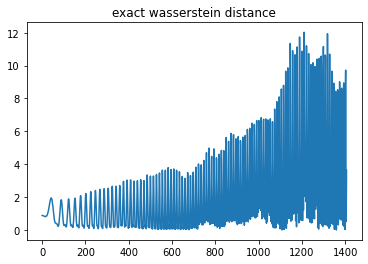

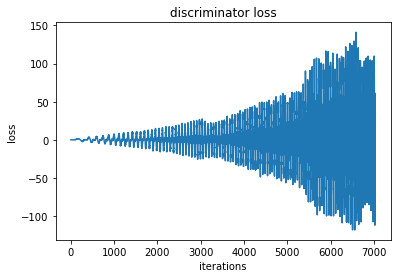

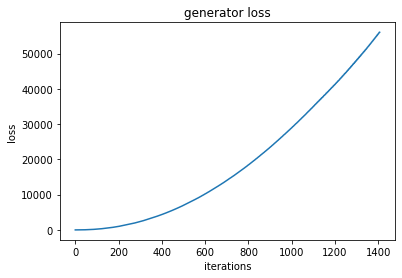

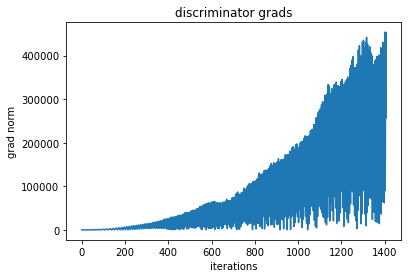

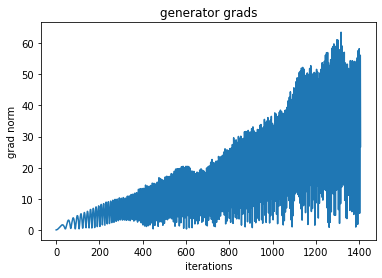

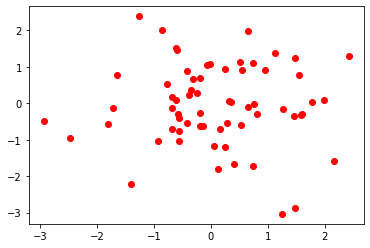

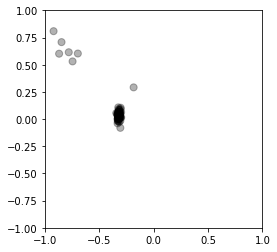

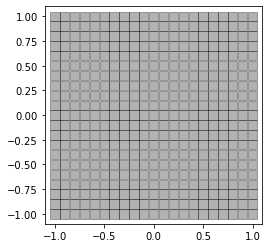

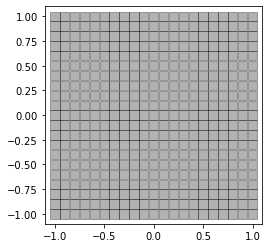

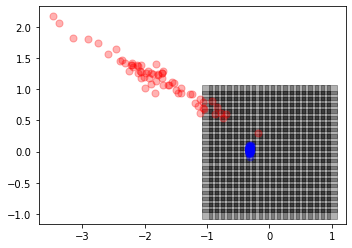

EP 201
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 202
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 203
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 204
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 205
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 206
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 207
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 208
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 209
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 210
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 211
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 212
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 213
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6

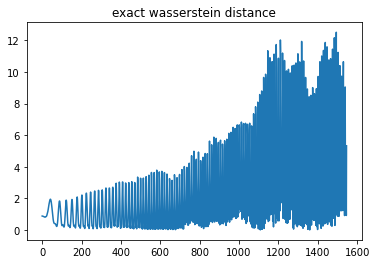

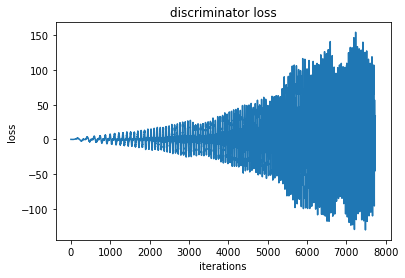

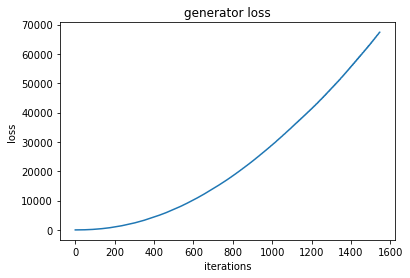

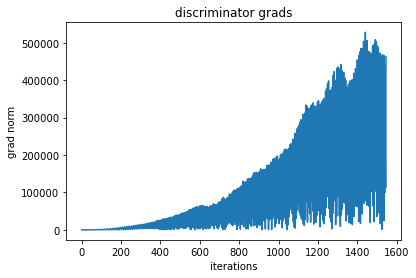

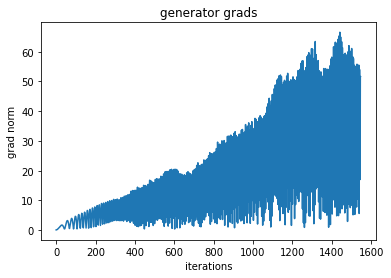

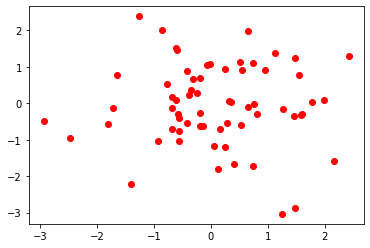

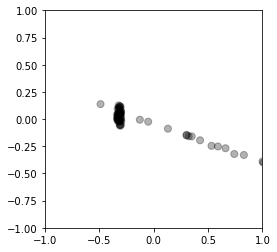

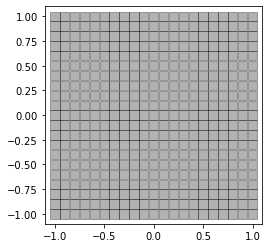

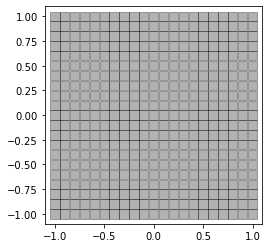

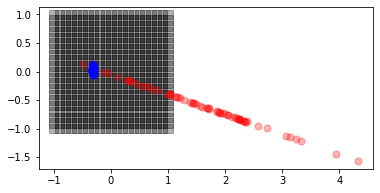

EP 221
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 222
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 223
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 224
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 225
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 226
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 227
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 228
batch # 0
batch # 1
batch # 2
batch # 3
Iteration 1600/14000: dis loss = 85.3780, gen loss = 71916.6797
batch # 4
batch # 5
batch # 6
EP 229
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 230
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 231
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 232
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 233
batch

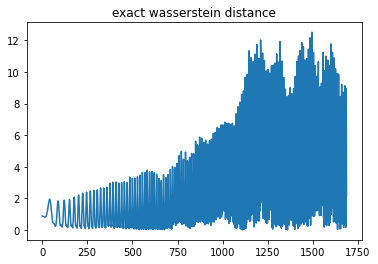

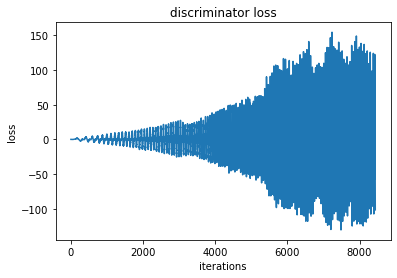

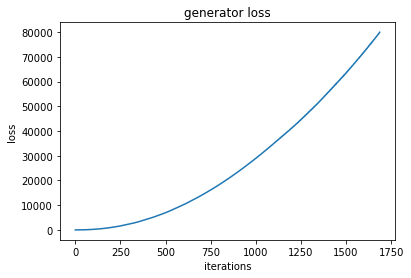

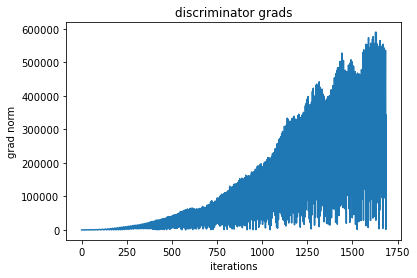

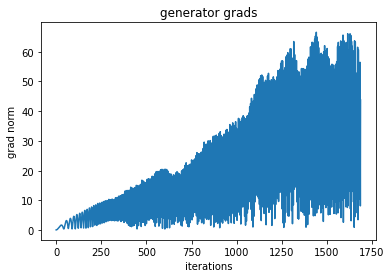

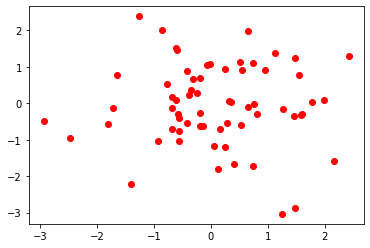

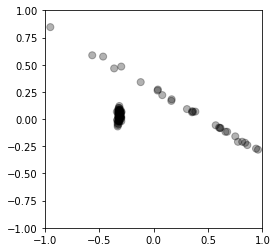

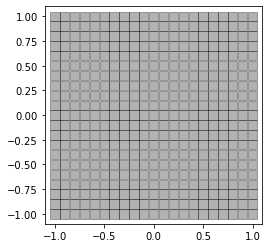

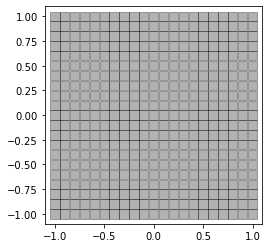

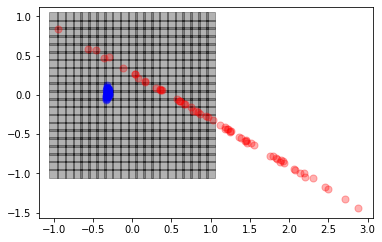

EP 241
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 242
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
Iteration 1700/14000: dis loss = -47.4760, gen loss = 81157.0078
batch # 6
EP 243
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 244
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 245
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 246
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 247
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 248
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 249
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 250
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 251
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 252
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 253
batc

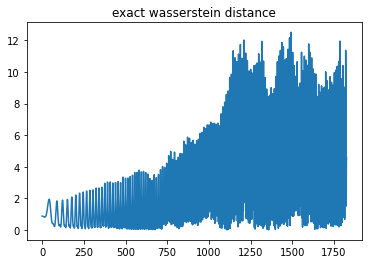

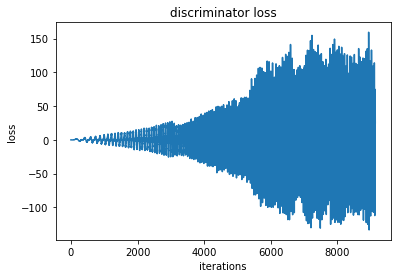

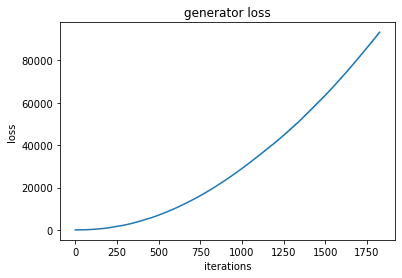

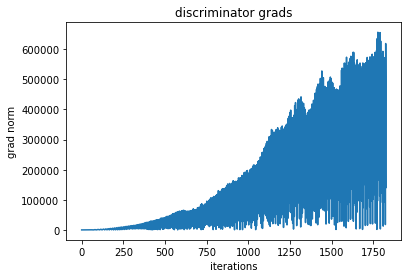

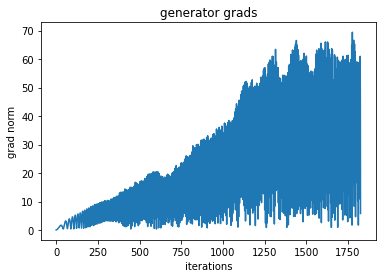

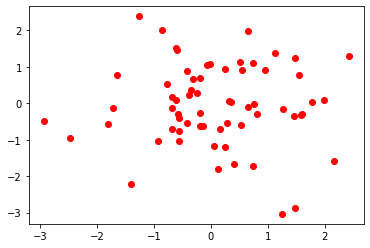

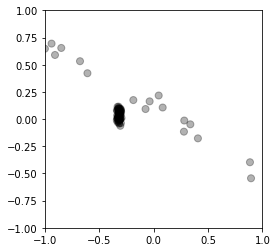

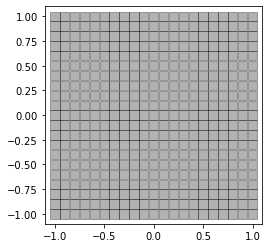

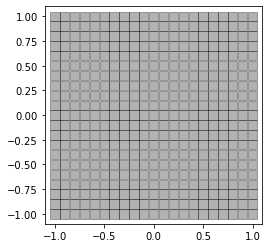

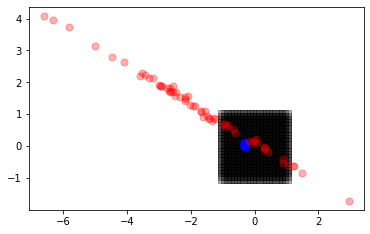

EP 261
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 262
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 263
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 264
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 265
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 266
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 267
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 268
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 269
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 270
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 271
batch # 0
batch # 1
batch # 2
Iteration 1900/14000: dis loss = -16.6306, gen loss = 100240.5156
batch # 3
batch # 4
batch # 5
batch # 6
EP 272
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 273
bat

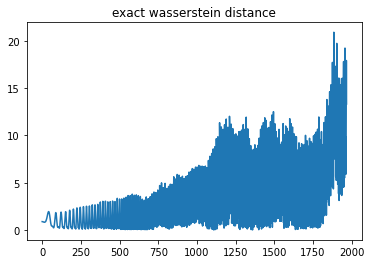

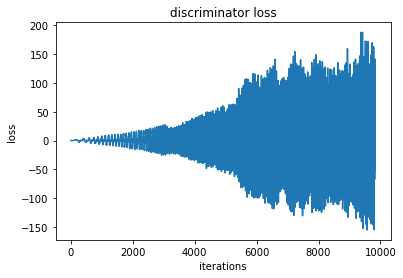

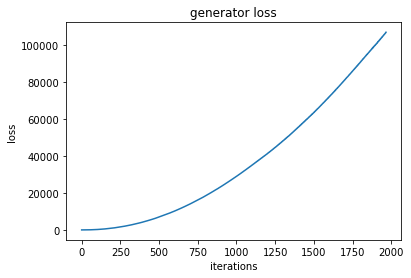

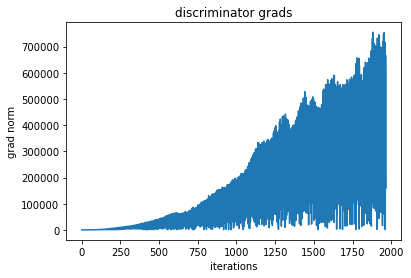

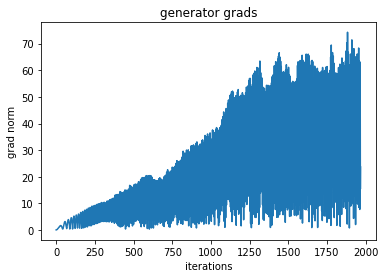

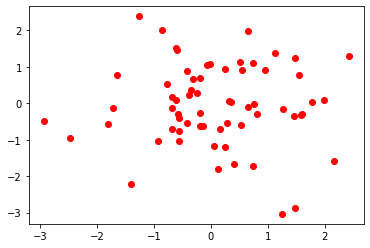

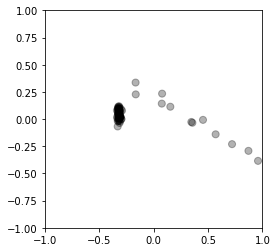

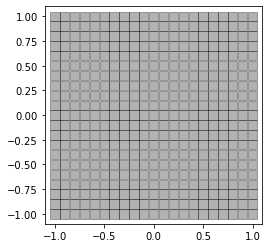

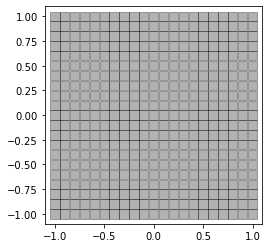

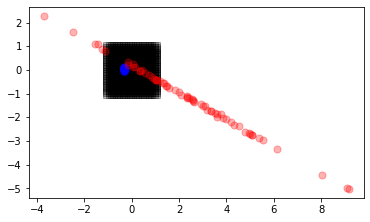

EP 281
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 282
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 283
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 284
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 285
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
Iteration 2000/14000: dis loss = -0.5419, gen loss = 110165.0781
batch # 5
batch # 6
EP 286
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 287
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 288
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 289
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 290
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 291
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 292
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 293
batc

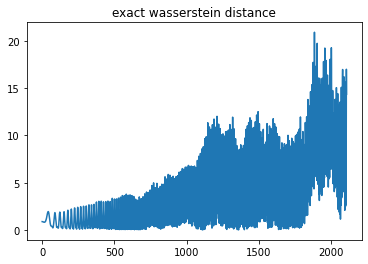

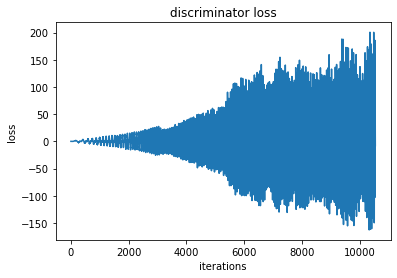

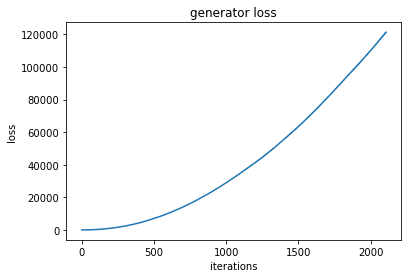

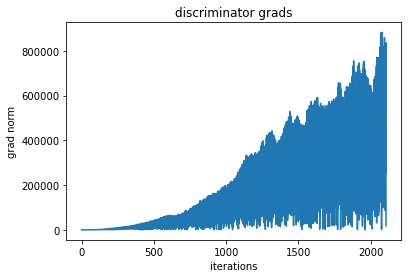

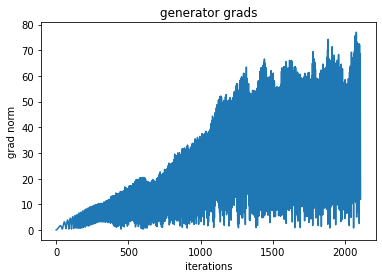

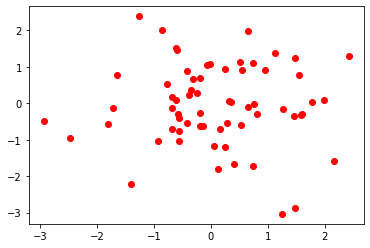

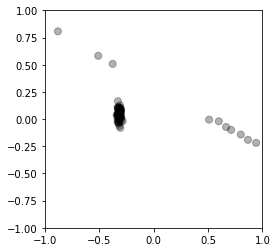

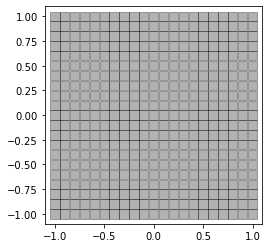

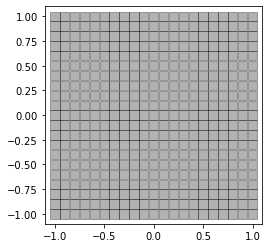

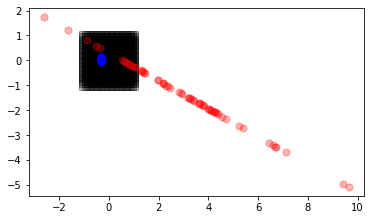

EP 301
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 302
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 303
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 304
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 305
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 306
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 307
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 308
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 309
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 310
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 311
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 312
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 313
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6

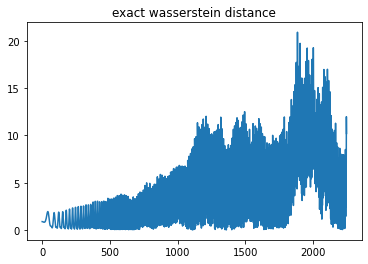

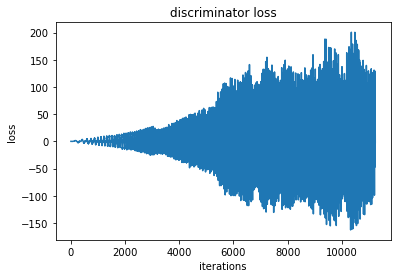

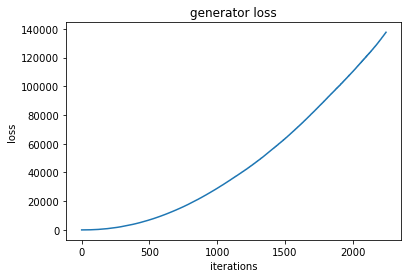

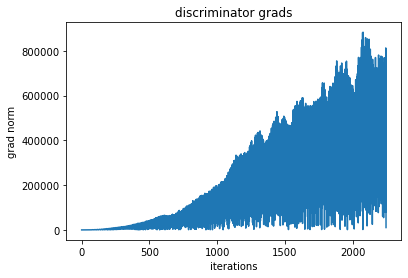

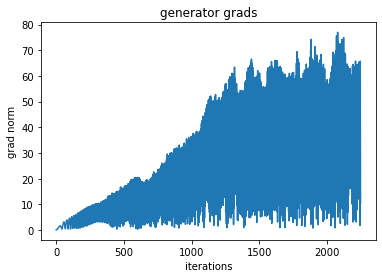

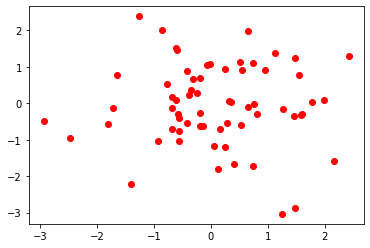

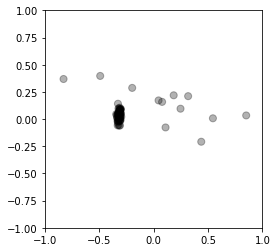

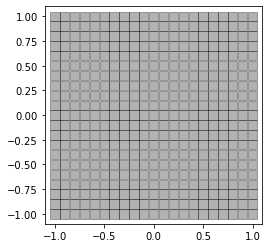

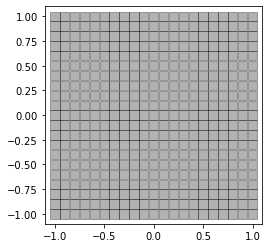

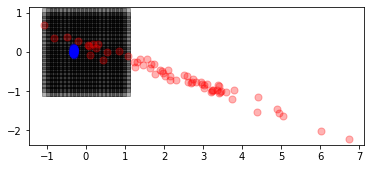

EP 321
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 322
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 323
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 324
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 325
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 326
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 327
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 328
batch # 0
batch # 1
batch # 2
batch # 3
Iteration 2300/14000: dis loss = -36.0259, gen loss = 144070.8750
batch # 4
batch # 5
batch # 6
EP 329
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 330
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 331
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 332
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 333
bat

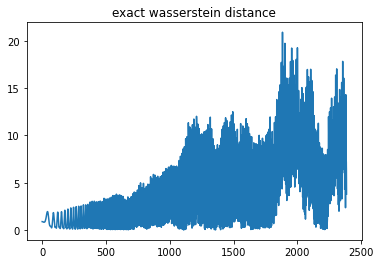

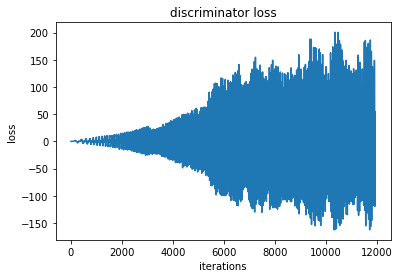

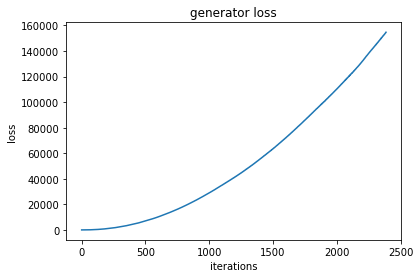

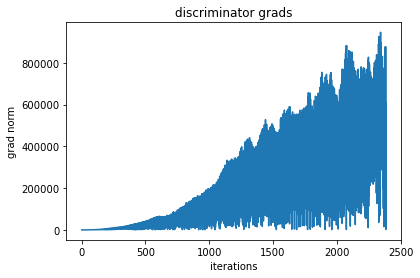

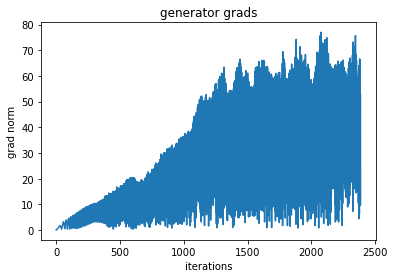

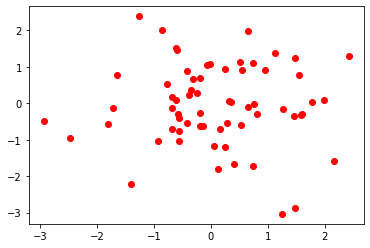

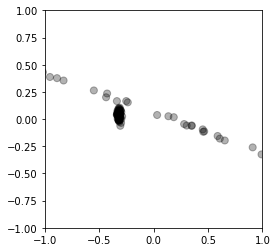

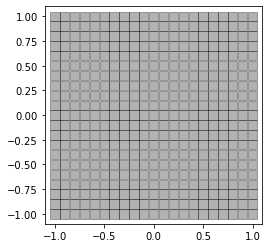

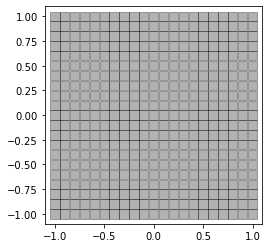

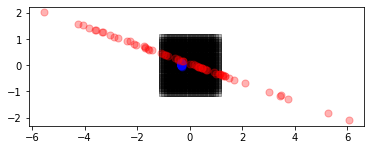

EP 341
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 342
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
Iteration 2400/14000: dis loss = -98.3439, gen loss = 156222.8906
batch # 6
EP 343
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 344
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 345
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 346
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 347
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 348
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 349
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 350
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 351
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 352
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 353
bat

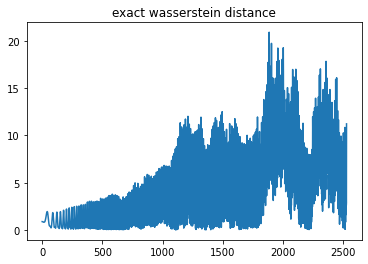

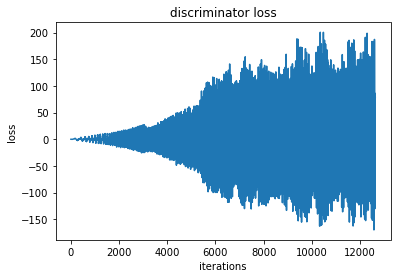

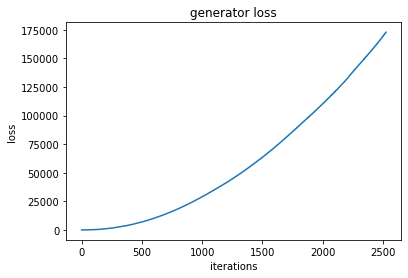

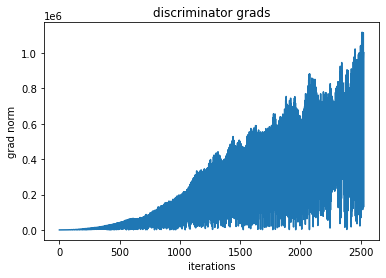

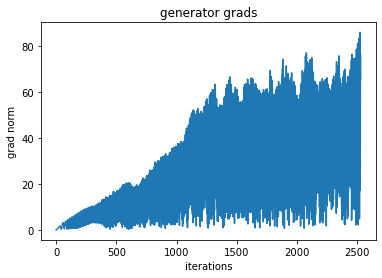

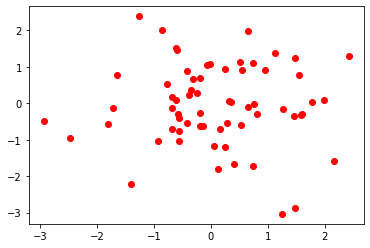

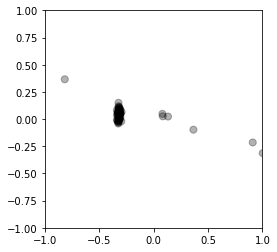

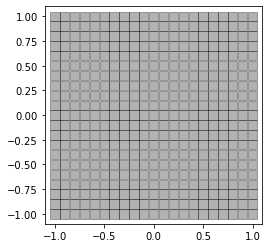

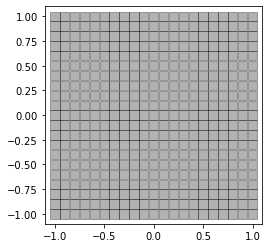

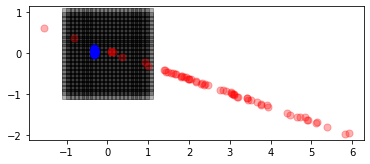

EP 361
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 362
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 363
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 364
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 365
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 366
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 367
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 368
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 369
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 370
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 371
batch # 0
batch # 1
batch # 2
Iteration 2600/14000: dis loss = -74.4652, gen loss = 182890.3438
batch # 3
batch # 4
batch # 5
batch # 6
EP 372
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 373
bat

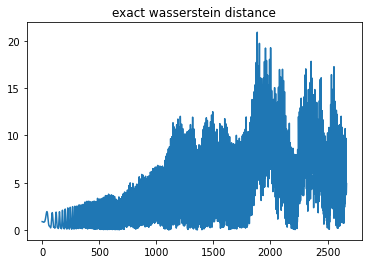

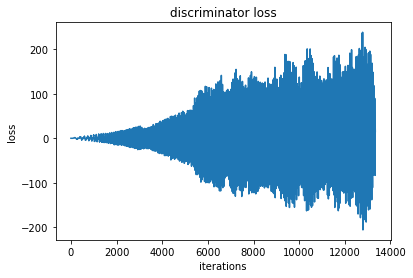

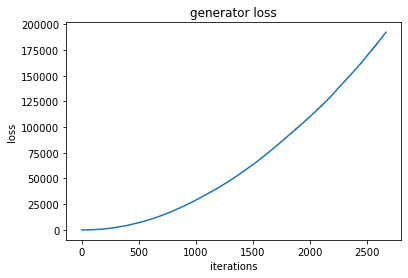

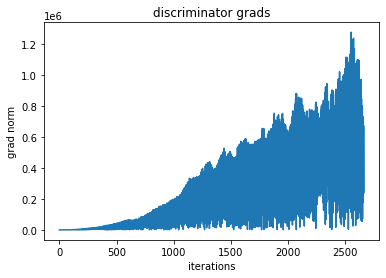

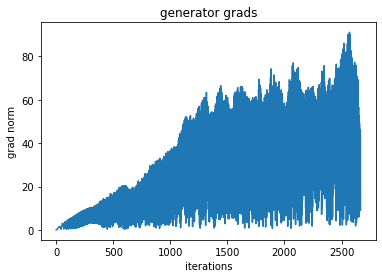

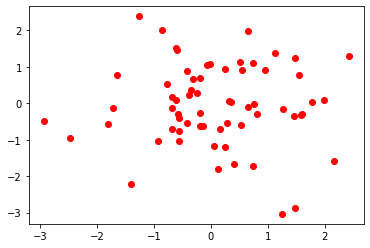

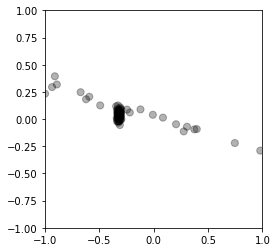

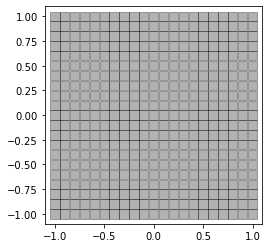

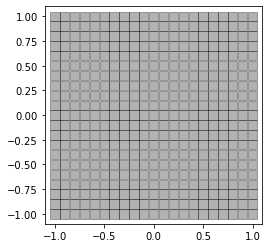

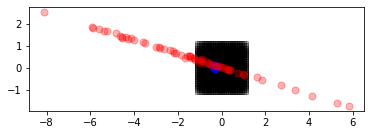

EP 381
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 382
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 383
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 384
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 385
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
Iteration 2700/14000: dis loss = -11.1807, gen loss = 196775.0781
batch # 5
batch # 6
EP 386
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 387
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 388
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 389
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 390
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 391
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 392
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 393
bat

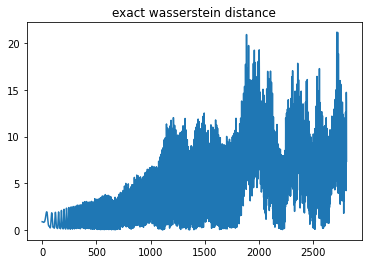

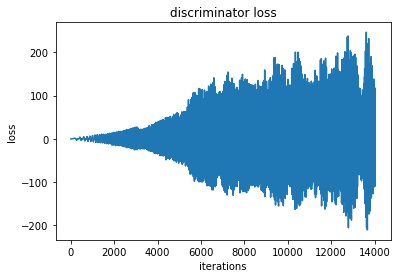

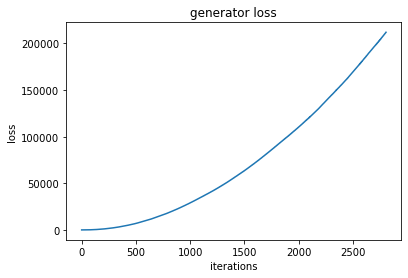

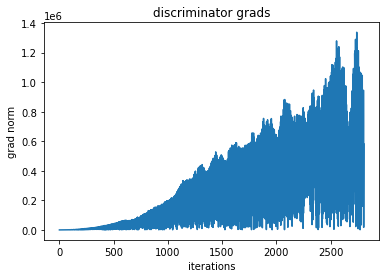

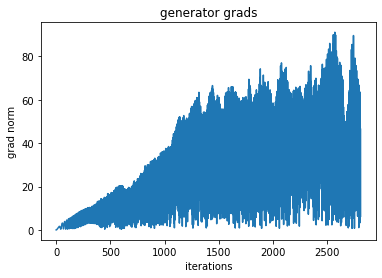

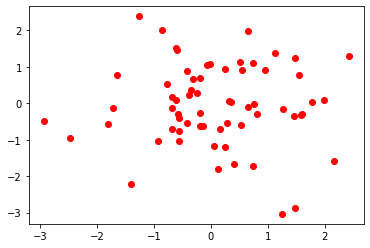

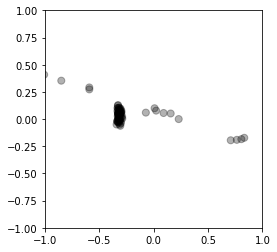

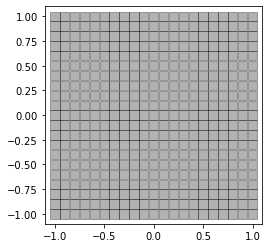

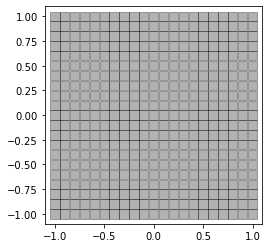

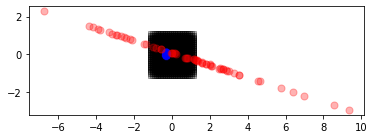

EP 401
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 402
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 403
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 404
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 405
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 406
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 407
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 408
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 409
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 410
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 411
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 412
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 413
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6

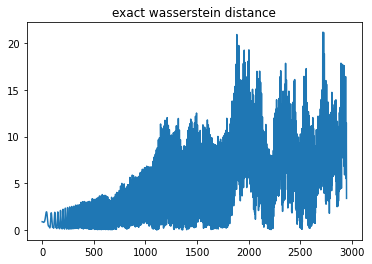

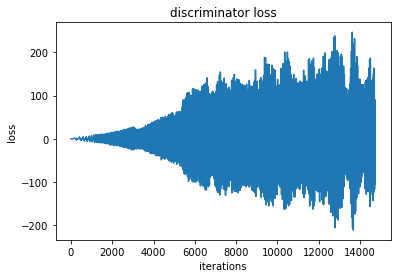

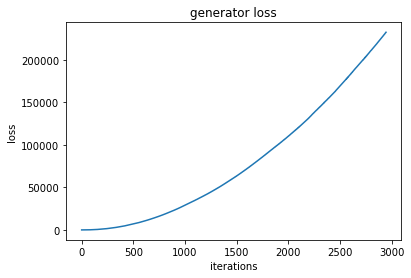

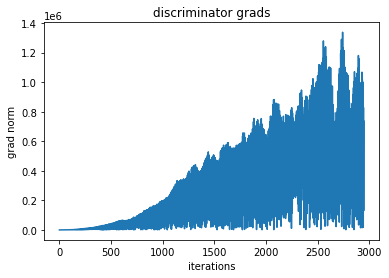

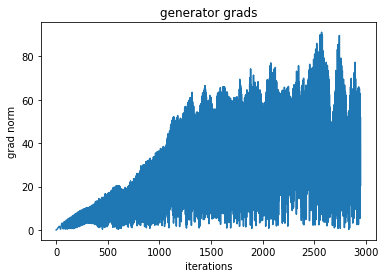

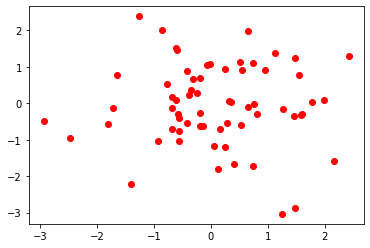

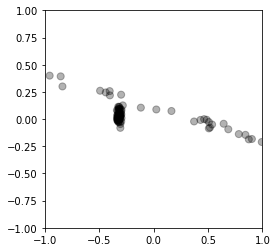

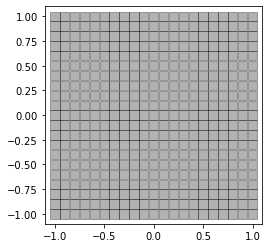

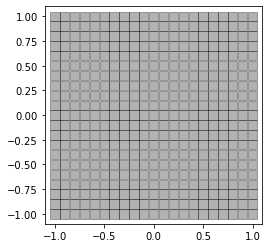

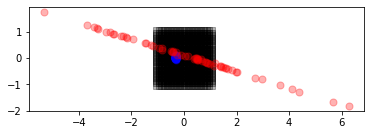

EP 421
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 422
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 423
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 424
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 425
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 426
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 427
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 428
batch # 0
batch # 1
batch # 2
batch # 3
Iteration 3000/14000: dis loss = -110.9144, gen loss = 241278.0938
batch # 4
batch # 5
batch # 6
EP 429
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 430
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 431
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 432
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 433
ba

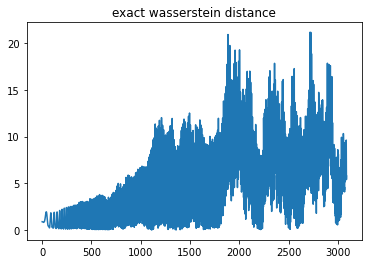

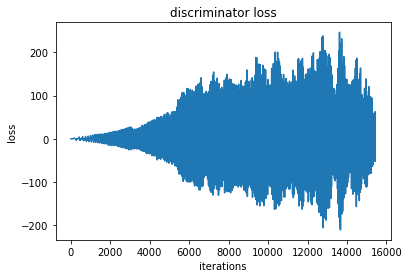

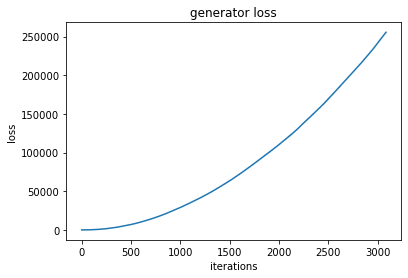

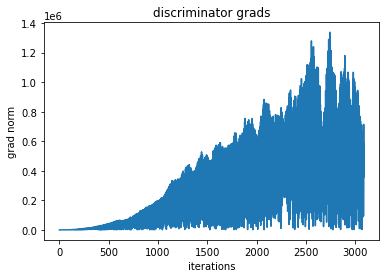

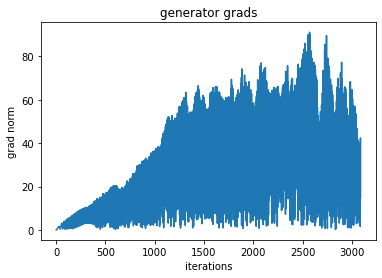

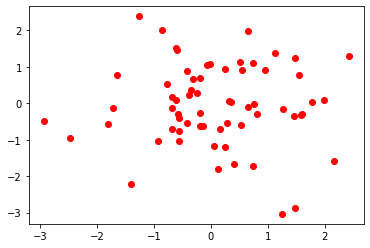

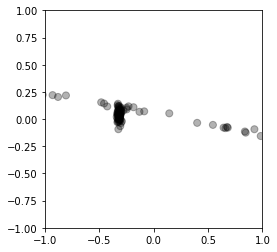

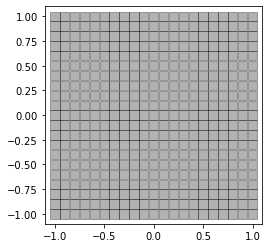

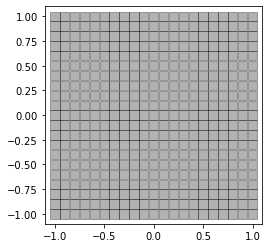

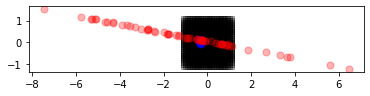

EP 441
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 442
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
Iteration 3100/14000: dis loss = -1.5950, gen loss = 257735.8906
batch # 6
EP 443
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 444
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 445
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 446
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 447
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 448
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 449
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 450
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 451
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 452
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 453
batc

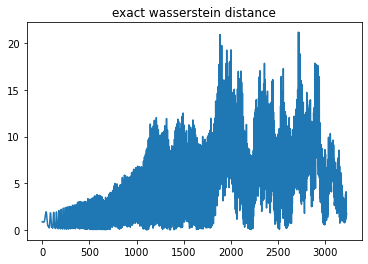

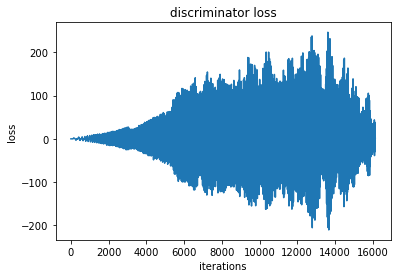

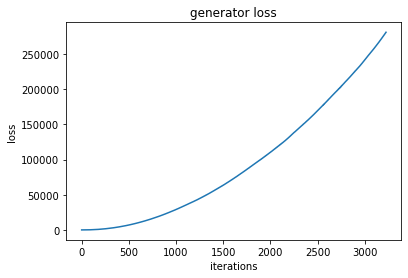

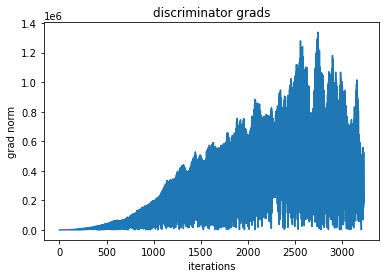

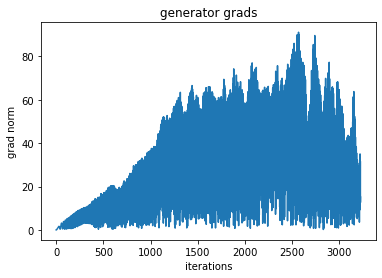

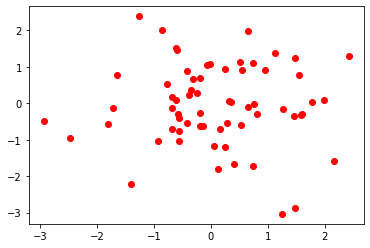

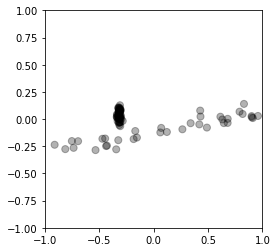

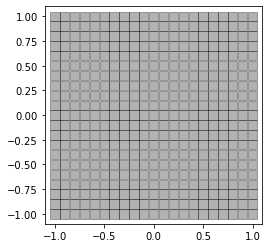

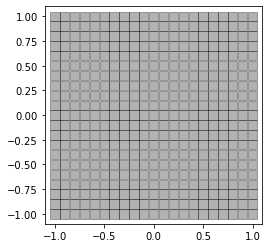

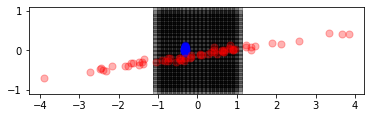

EP 461
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 462
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 463
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 464
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 465
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 466
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 467
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 468
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 469
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 470
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 471
batch # 0
batch # 1
batch # 2
Iteration 3300/14000: dis loss = 1.1272, gen loss = 294963.6250
batch # 3
batch # 4
batch # 5
batch # 6
EP 472
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 473
batch

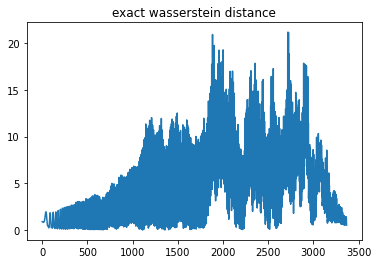

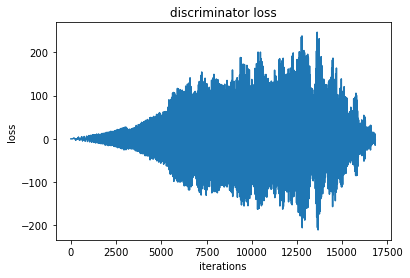

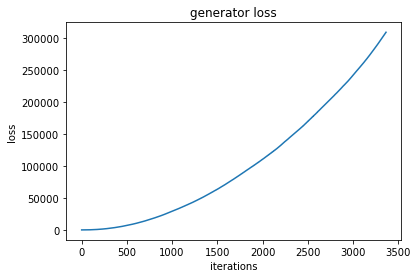

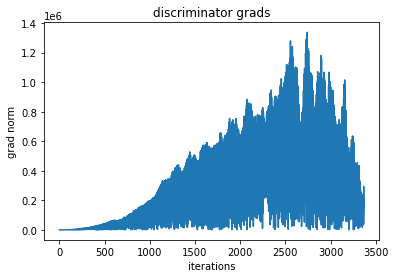

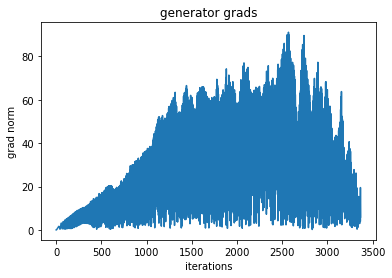

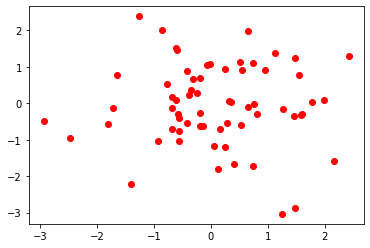

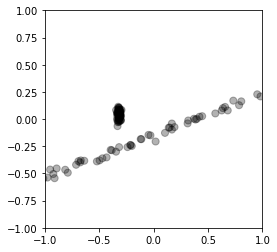

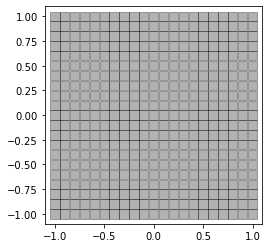

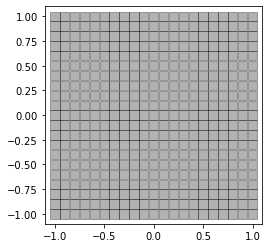

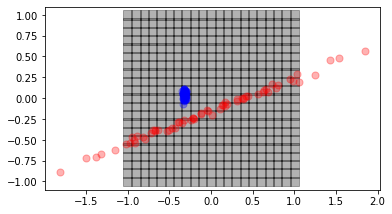

EP 481
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 482
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 483
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 484
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 485
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
Iteration 3400/14000: dis loss = -9.8889, gen loss = 315776.0000
batch # 5
batch # 6
EP 486
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 487
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 488
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 489
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 490
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 491
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 492
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 493
batc

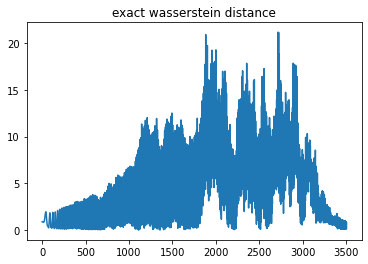

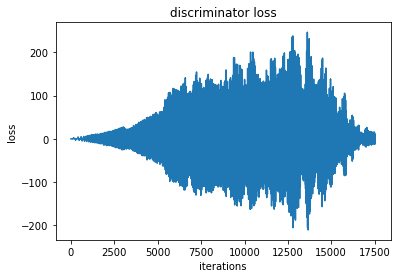

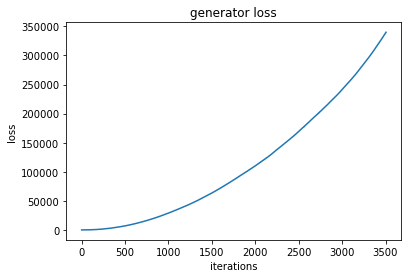

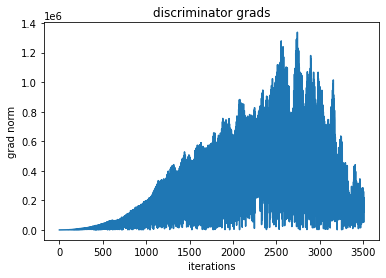

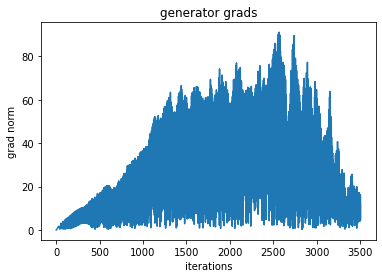

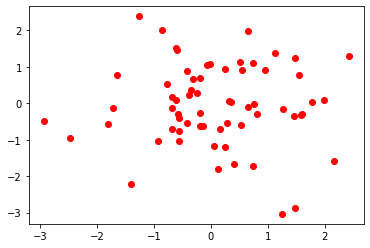

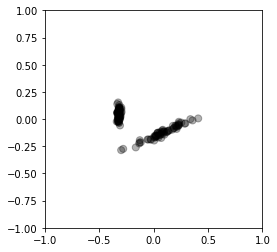

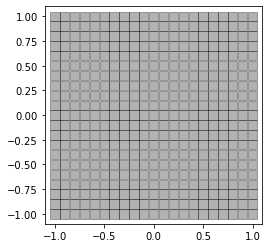

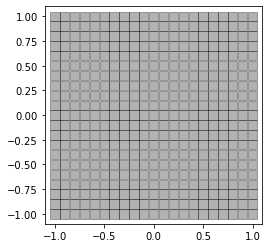

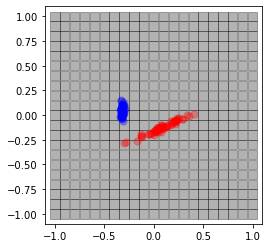

EP 501
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 502
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 503
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 504
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 505
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 506
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 507
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 508
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 509
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 510
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 511
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 512
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 513
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6

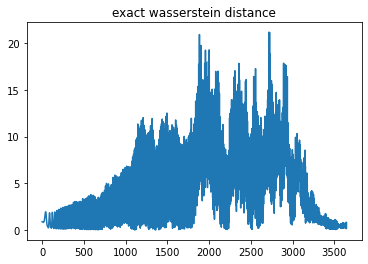

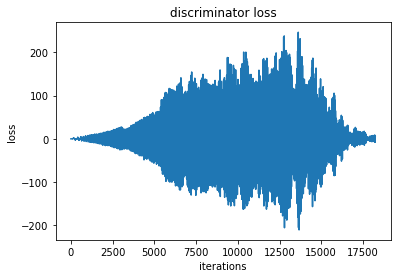

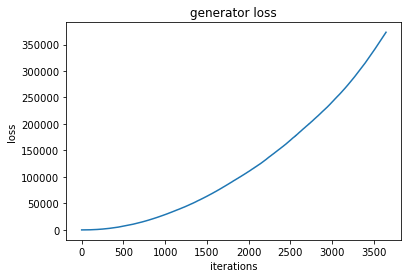

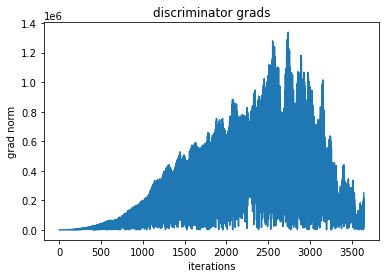

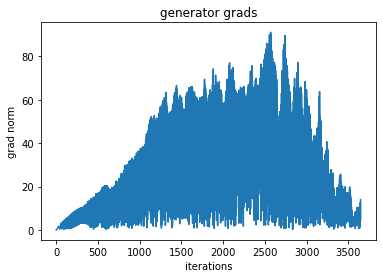

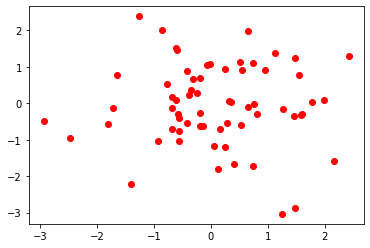

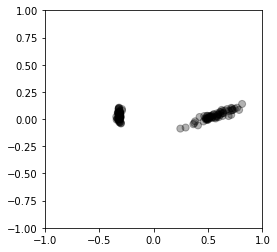

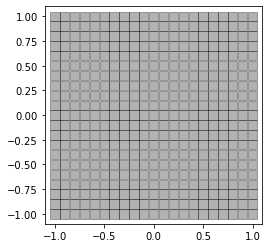

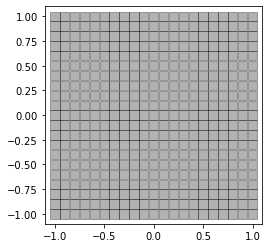

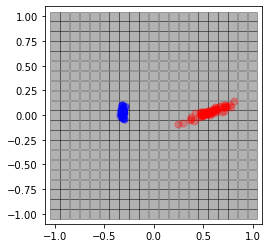

EP 521
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 522
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 523
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 524
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 525
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 526
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 527
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 528
batch # 0
batch # 1
batch # 2
batch # 3
Iteration 3700/14000: dis loss = 6.9246, gen loss = 386114.4688
batch # 4
batch # 5
batch # 6
EP 529
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 530
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 531
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 532
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 533
batch

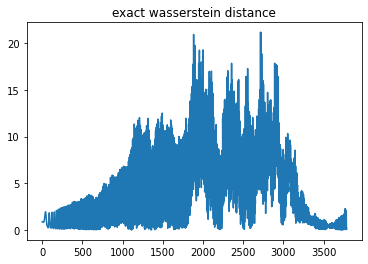

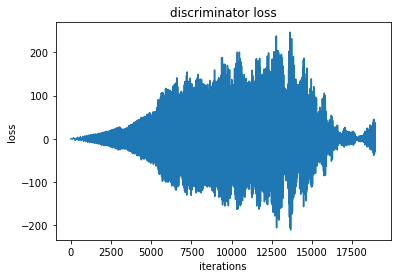

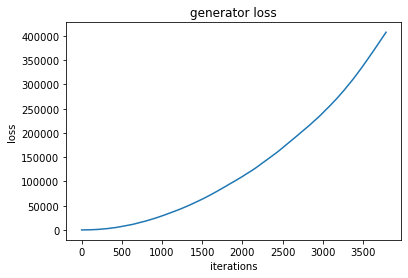

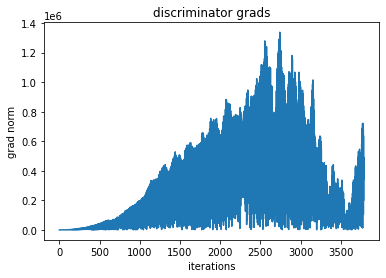

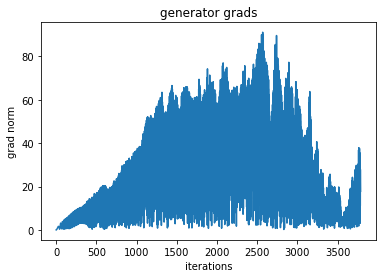

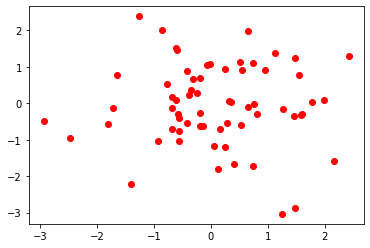

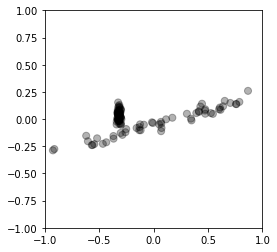

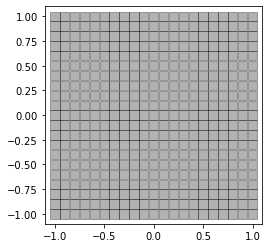

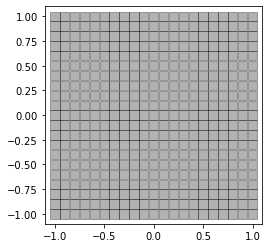

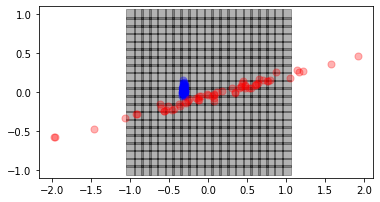

EP 541
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 542
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
Iteration 3800/14000: dis loss = -1.7754, gen loss = 410748.8438
batch # 6
EP 543
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 544
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 545
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 546
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 547
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 548
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 549
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 550
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 551
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 552
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 553
batc

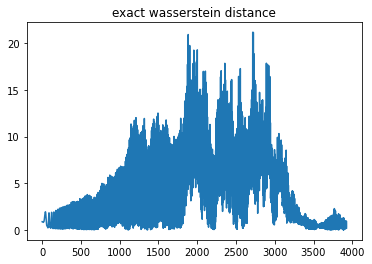

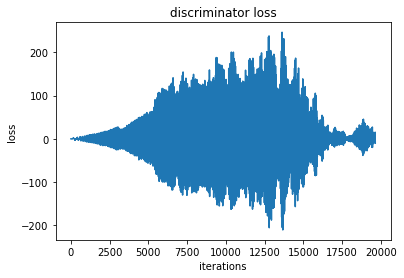

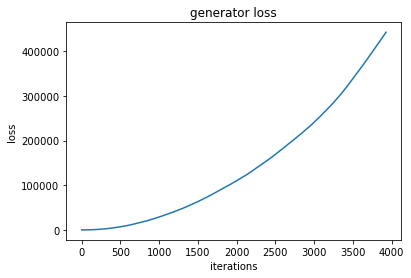

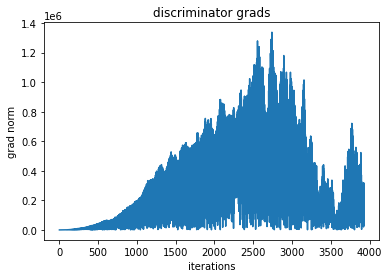

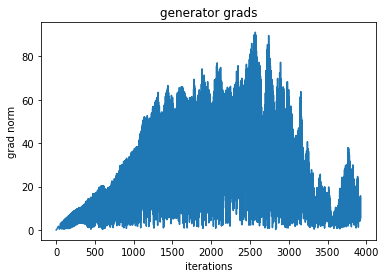

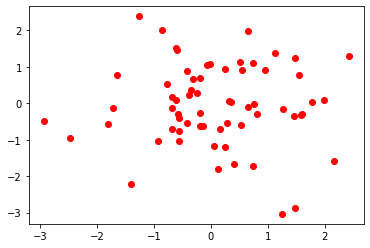

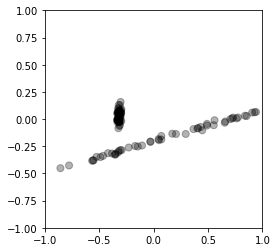

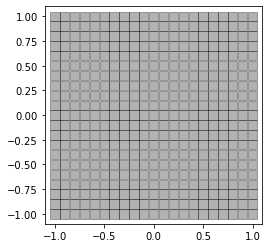

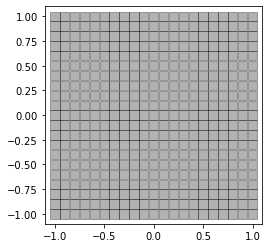

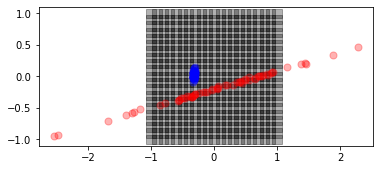

EP 561
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 562
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 563
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 564
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 565
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 566
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 567
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 568
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 569
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 570
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 571
batch # 0
batch # 1
batch # 2
Iteration 4000/14000: dis loss = -5.1260, gen loss = 461380.8125
batch # 3
batch # 4
batch # 5
batch # 6
EP 572
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 573
batc

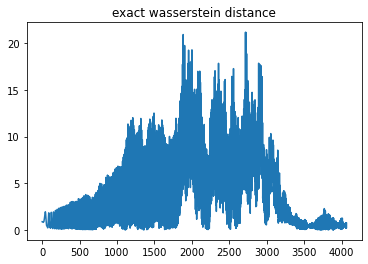

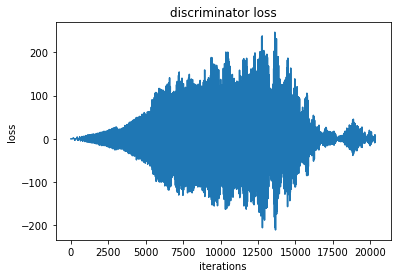

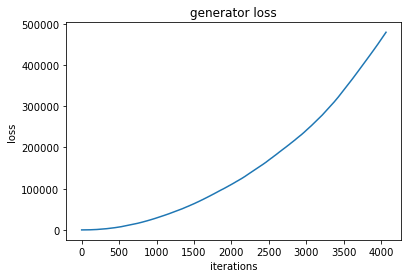

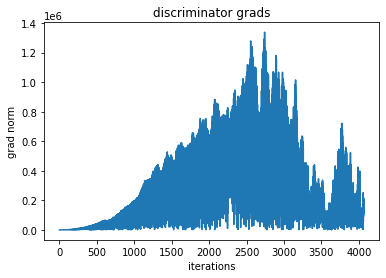

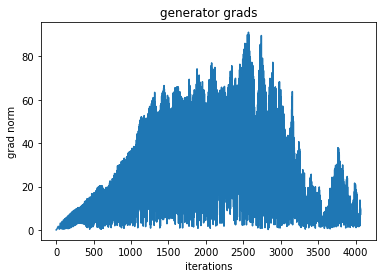

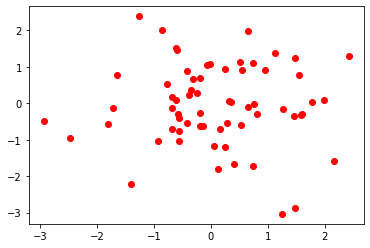

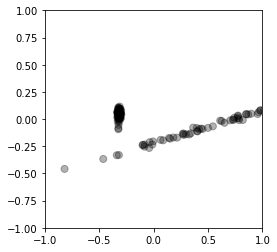

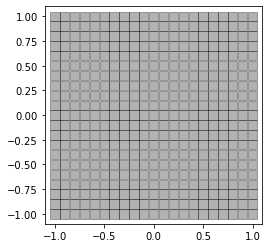

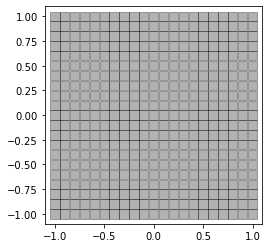

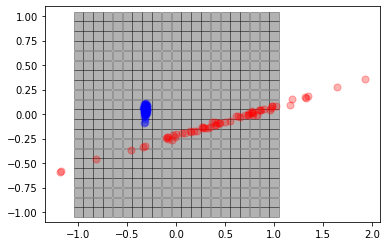

EP 581
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 582
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 583
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 584
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 585
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
Iteration 4100/14000: dis loss = -1.0432, gen loss = 488289.5625
batch # 5
batch # 6
EP 586
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 587
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 588
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 589
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 590
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 591
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 592
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 593
batc

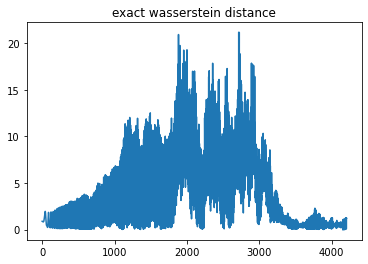

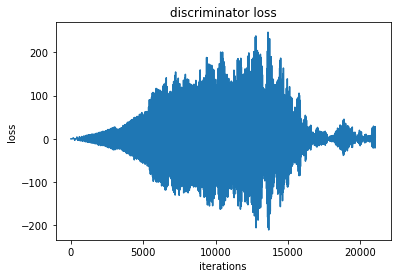

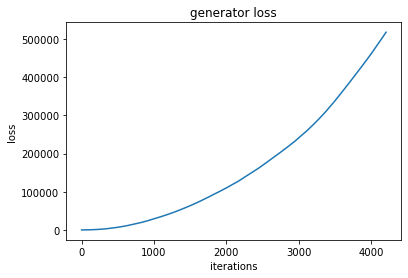

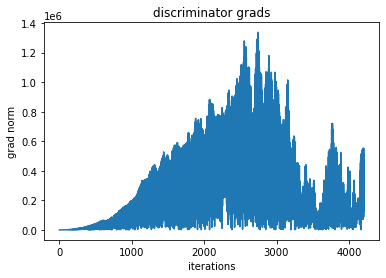

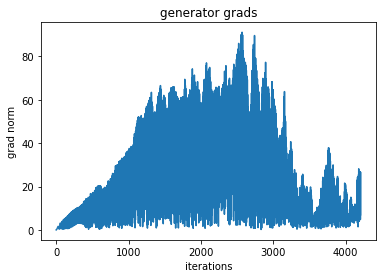

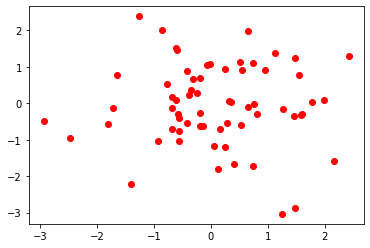

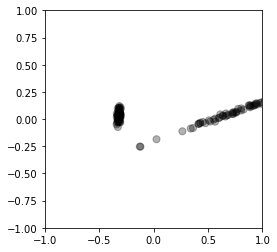

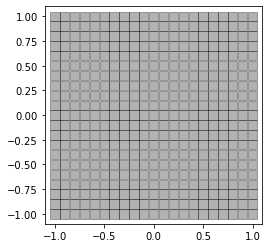

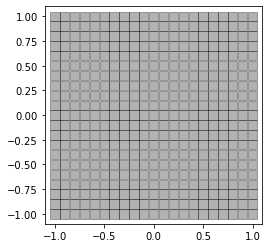

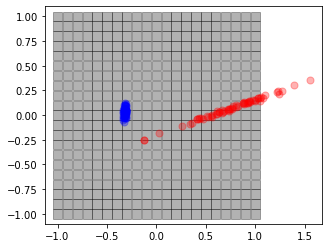

EP 601
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 602
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 603
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 604
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 605
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 606
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 607
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 608
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 609
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 610
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 611
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 612
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 613
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6

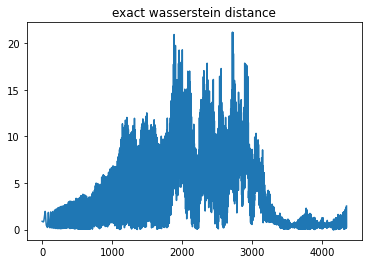

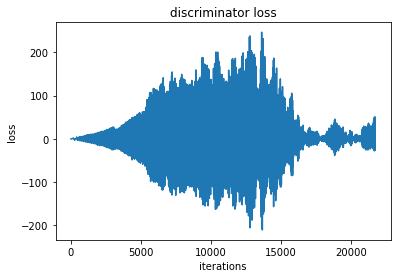

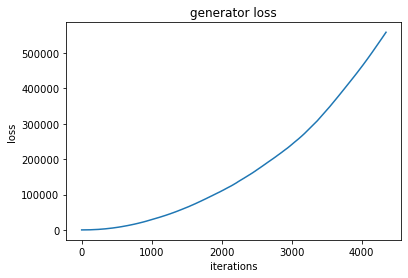

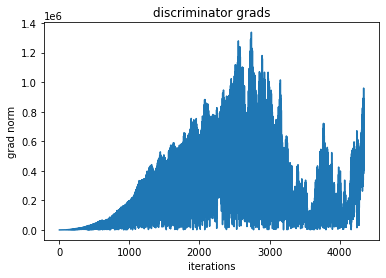

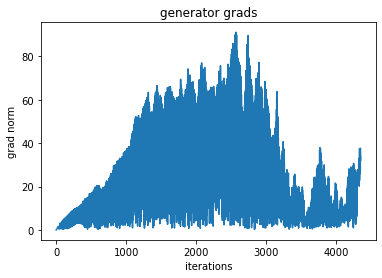

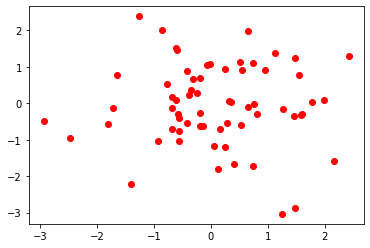

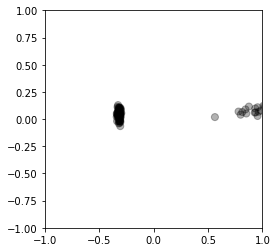

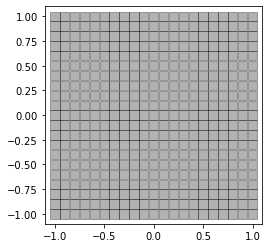

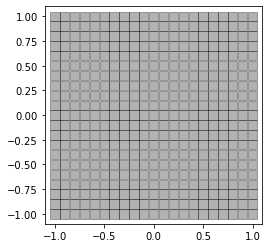

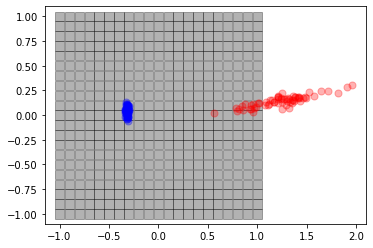

EP 621
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 622
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 623
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 624
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 625
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 626
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 627
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 628
batch # 0
batch # 1
batch # 2
batch # 3
Iteration 4400/14000: dis loss = 1.1958, gen loss = 573334.8750
batch # 4
batch # 5
batch # 6
EP 629
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 630
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 631
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 632
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 633
batch

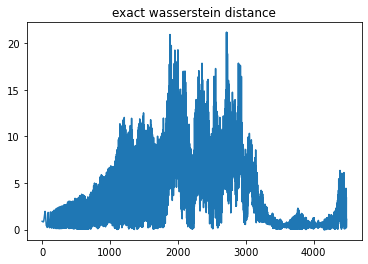

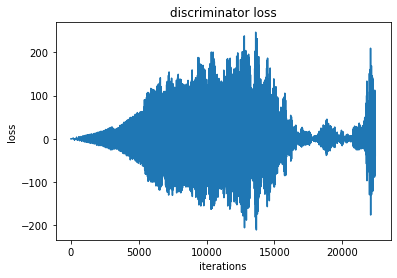

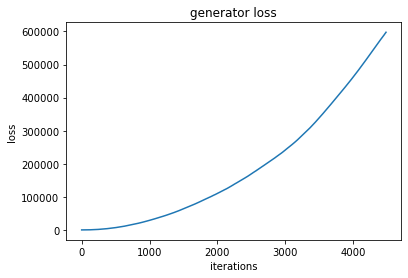

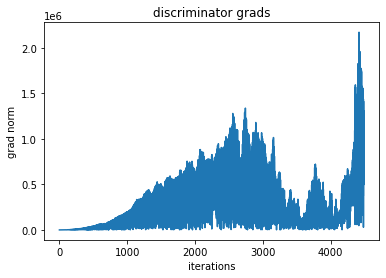

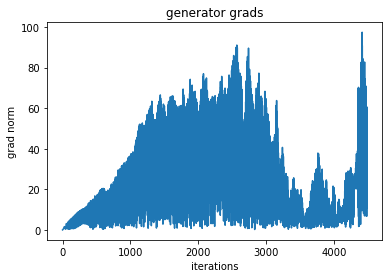

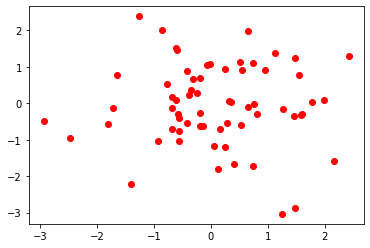

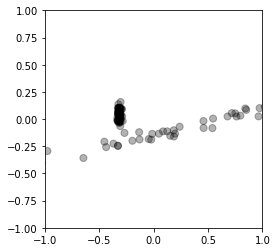

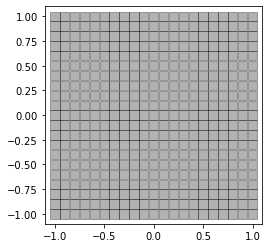

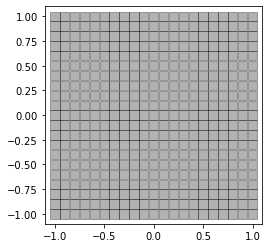

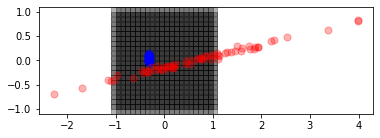

EP 641
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 642
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
Iteration 4500/14000: dis loss = -4.6377, gen loss = 601182.3125
batch # 6
EP 643
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 644
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 645
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 646
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 647
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 648
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 649
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 650
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 651
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 652
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 653
batc

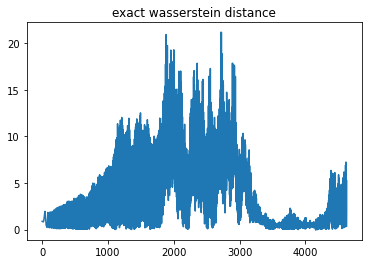

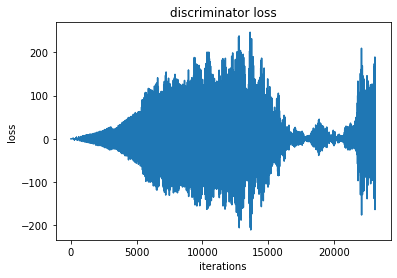

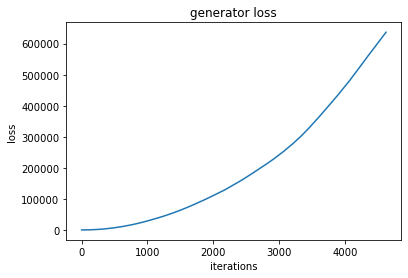

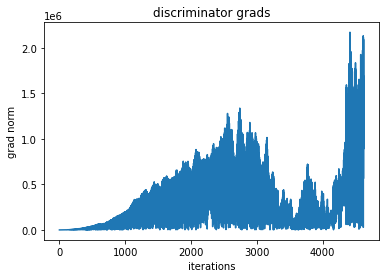

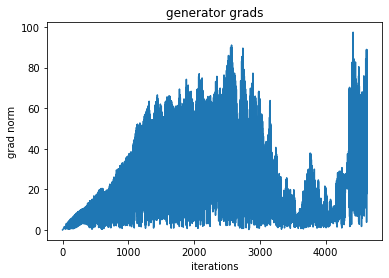

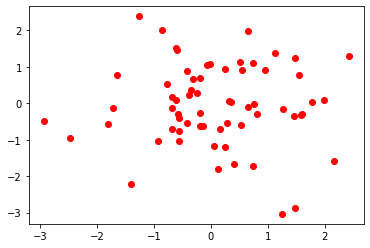

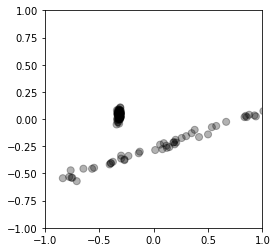

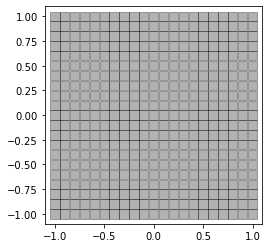

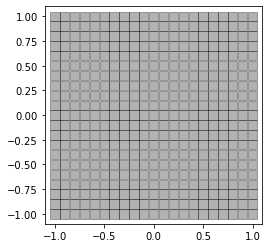

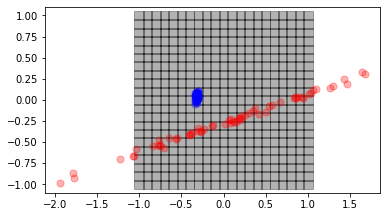

EP 661
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 662
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 663
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 664
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 665
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 666
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 667
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 668
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 669
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 670
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 671
batch # 0
batch # 1
batch # 2
Iteration 4700/14000: dis loss = 56.0942, gen loss = 656993.0625
batch # 3
batch # 4
batch # 5
batch # 6
EP 672
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 673
batc

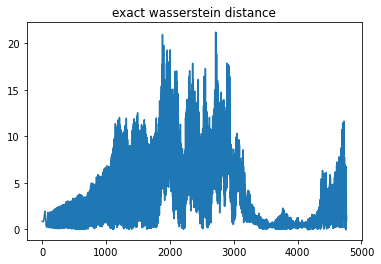

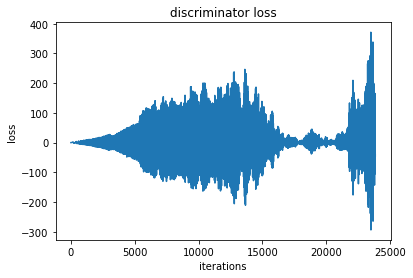

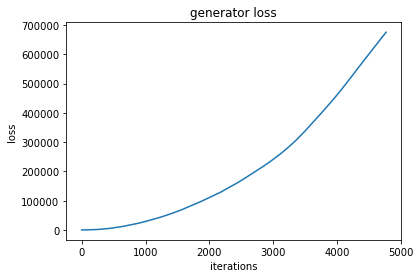

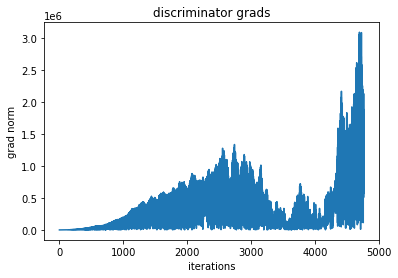

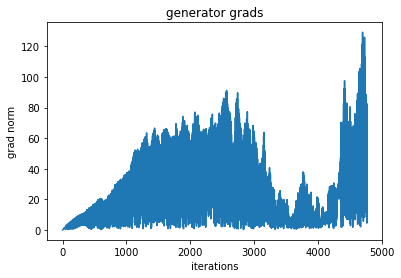

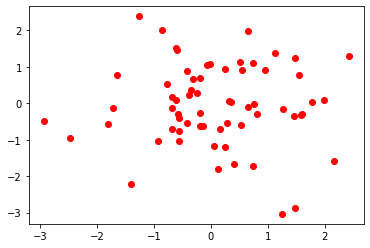

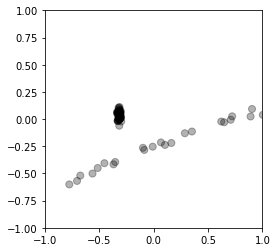

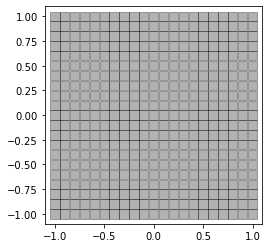

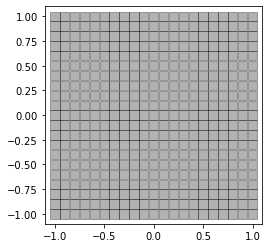

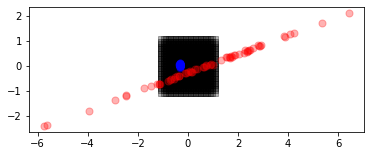

EP 681
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 682
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 683
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 684
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 685
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
Iteration 4800/14000: dis loss = 98.3364, gen loss = 684279.7500
batch # 5
batch # 6
EP 686
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 687
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 688
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 689
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 690
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 691
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 692
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 693
batc

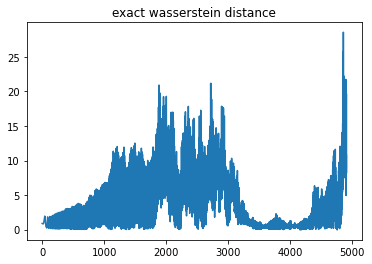

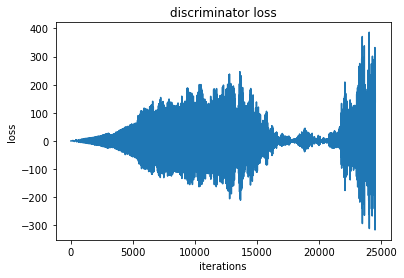

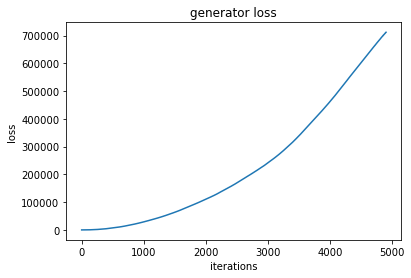

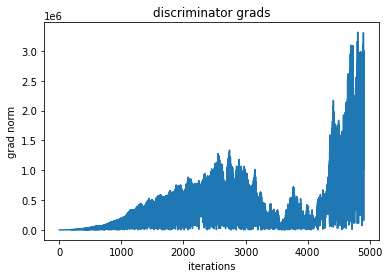

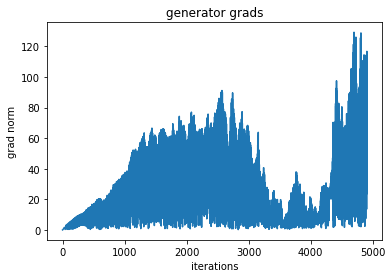

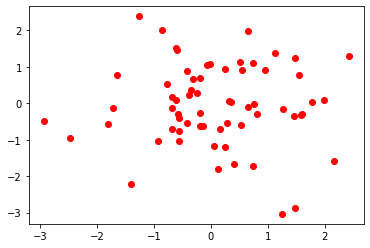

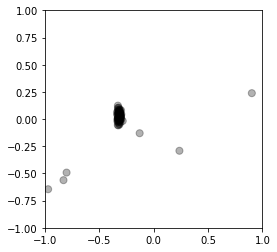

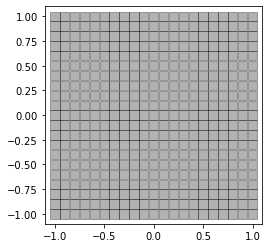

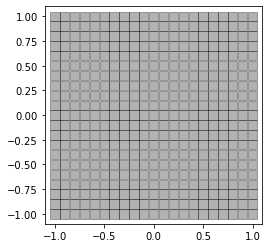

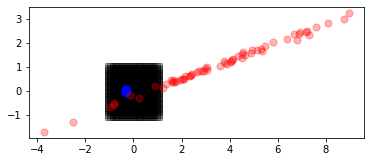

EP 701
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 702
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 703
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 704
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 705
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 706
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 707
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 708
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 709
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 710
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 711
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 712
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 713
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6

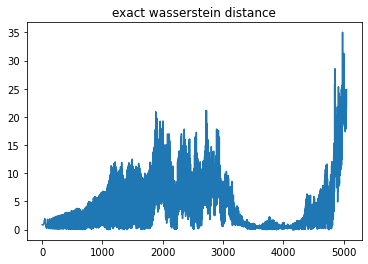

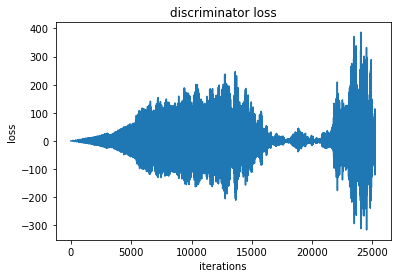

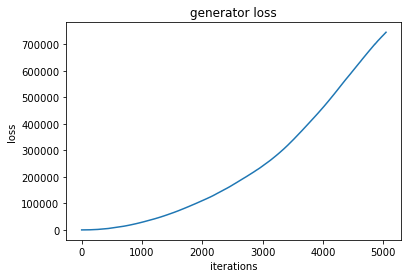

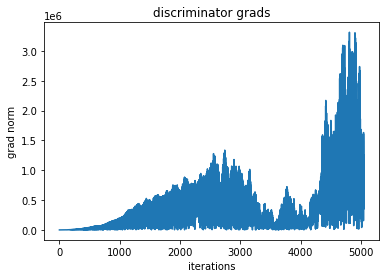

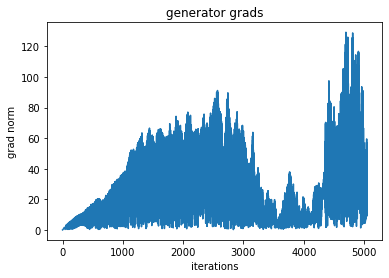

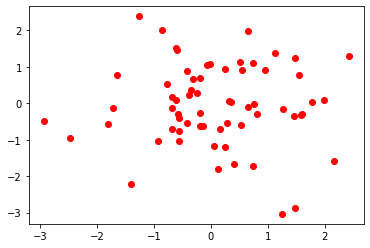

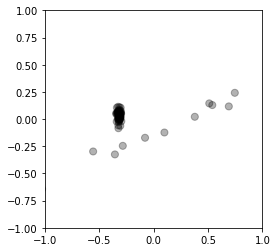

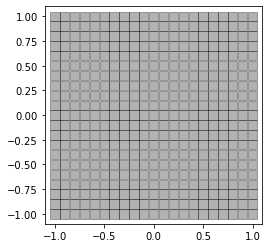

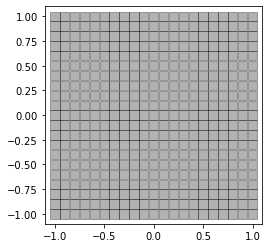

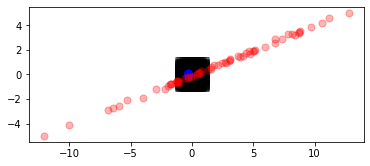

EP 721
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 722
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 723
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 724
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 725
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 726
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 727
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 728
batch # 0
batch # 1
batch # 2
batch # 3
Iteration 5100/14000: dis loss = -2.5645, gen loss = 758548.1250
batch # 4
batch # 5
batch # 6
EP 729
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 730
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 731
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 732
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 733
batc

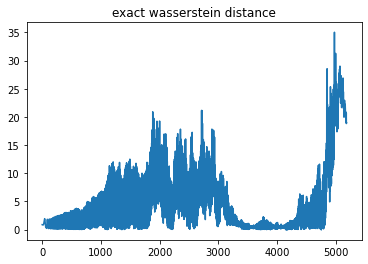

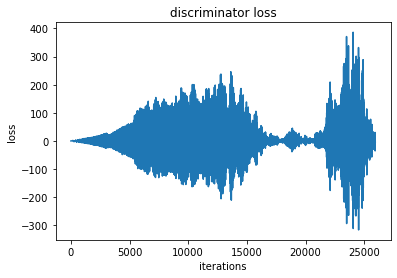

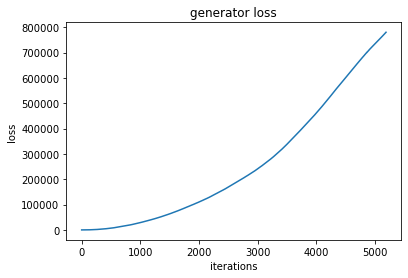

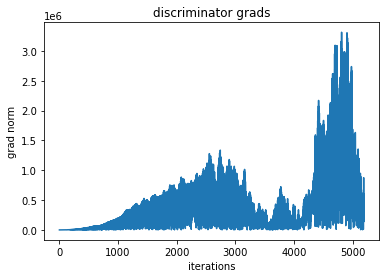

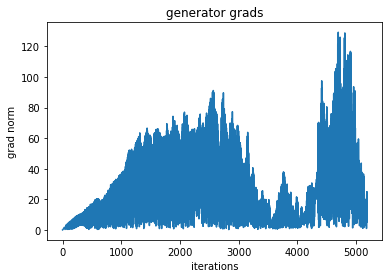

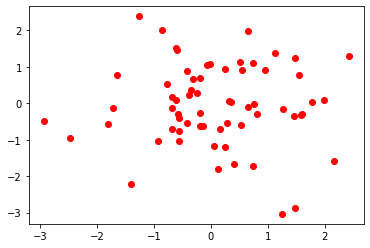

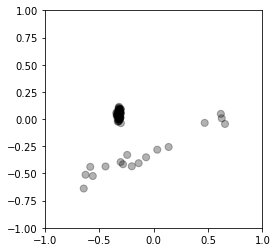

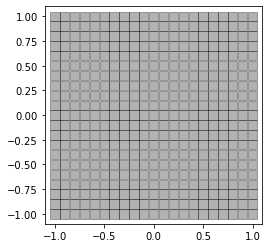

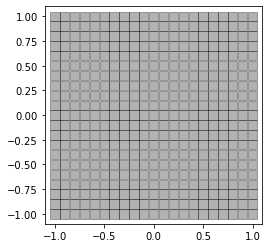

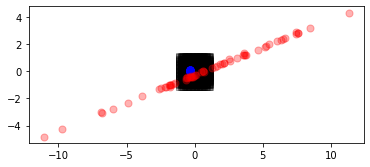

EP 741
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 742
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
Iteration 5200/14000: dis loss = 2.6885, gen loss = 783311.0625
batch # 6
EP 743
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 744
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 745
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 746
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 747
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 748
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 749
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 750
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 751
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 752
batch # 0
batch # 1
batch # 2
batch # 3
batch # 4
batch # 5
batch # 6
EP 753
batch

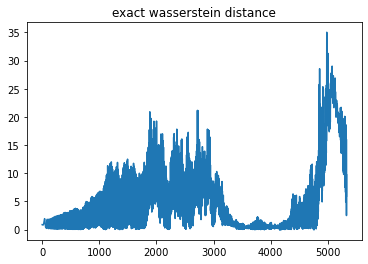

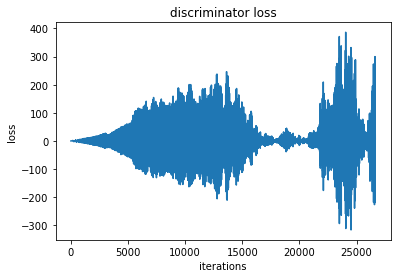

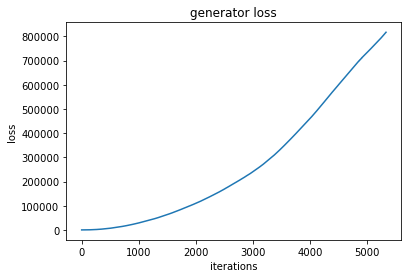

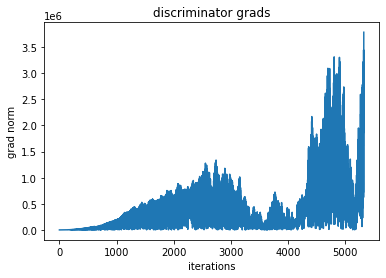

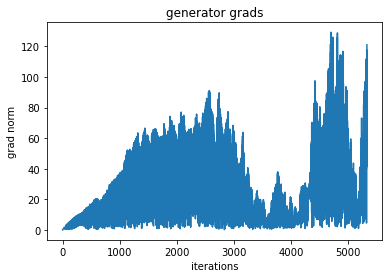

In [ ]:
set_seed(42)

EP = 2000

dlayers = [2,8,6,4,1]
dloss = 1e-3
glayers = [2,2]
gloss = 3e-2

dlayers = [2,32,16,16,1]
dlayers = [2,16,16,1]
dloss = 3e-4

nm = 0.0
mg = 1.0
mg  = 1000.
from opacus.autograd_grad_sample import disable_hooks
disable_hooks()

#simpgan = SimpGAN(dlayers, glayers,dloss,gloss,EP)
simpgan = SimpWGANGP(dlayers, glayers,dloss,gloss,EP,
                     sample_size=train_samples.shape[0],compute_exact_w=True,privacy=True,nm=nm,mg=mg)
simpgan.train(train_samples)
torch.save(simpgan.state_dict(), "simpgan.pth")